## Amazon Review Dataset - Identify Review helpfulness for the Category "Automotive"
<font color='green'>
<b>Subject:</b> Data 270 <br/>
<b>Group:</b> 5 <br/>
<b>Name:</b> Monica Lokare <br/>
<b>Individual Category:</b> Automotive <br/>
<b>SJSU ID:017422938 </b></font>

In [1]:
import pandas as pd  # Importing pandas library for data manipulation and analysis
import numpy as np  # Importing numpy library for numerical computing
import re  # Importing re module for regular expressions
import matplotlib.pyplot as plt  # Importing matplotlib library for data visualization
import datetime  # Importing datetime module for date and time manipulation
from datetime import datetime  # Importing datetime class from datetime module
import random  # Importing random module for generating random numbers
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # Importing plotly for interactive plots
import plotly.express as px  # Importing plotly express for easy plotting
import plotly.graph_objects as go  # Importing plotly graph objects for advanced plotting
import plotly.figure_factory as ff  # Importing plotly figure factory for creating complex visualizations
from plotly.colors import n_colors  # Importing plotly colors for color management
import seaborn as sns  # Importing seaborn for statistical data visualization
from plotly.subplots import make_subplots  # Importing plotly subplots for creating multiple plots
import squarify  # Importing squarify for tree map plotting
from collections import Counter  # Importing Counter for counting hashable objects
init_notebook_mode(connected=True)  # Initializing plotly notebook mode for offline plotting
from wordcloud import WordCloud , ImageColorGenerator  # Importing wordcloud for creating word clouds
import nltk as nltk  # Importing nltk for natural language processing tasks
import string  # Importing string module for string manipulation
import re  # For regular expressions
import string  # For string operations
import contractions  # For expanding contractions
from nltk.corpus import stopwords  # For accessing stopwords list
from nltk.tokenize import word_tokenize  # Importing word_tokenize for tokenization
from nltk.corpus import stopwords  # Importing stopwords for removing common words
from sklearn.feature_extraction.text import TfidfVectorizer  # Importing TfidfVectorizer for text feature extraction
from textblob import TextBlob  # Importing TextBlob for sentiment analysis
from nltk.corpus import stopwords  # Importing stopwords again (duplicate import)
from textblob import TextBlob  # Importing TextBlob again (duplicate import)
import emoji  # Importing emoji for working with emojis
import contractions  # Importing contractions for expanding contractions in text
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer  # Importing stemmers and lemmatizer for word normalization
from collections import Counter  # Importing Counter again (duplicate import)
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting data into train and test sets
from xgboost import XGBClassifier  # Importing XGBoost classifier
from sklearn.metrics import accuracy_score, classification_report  # Importing accuracy_score and classification_report for model evaluation
import squarify

In [3]:
# Reading in Automotive data from the CSV file named 'Automotive_data.csv' and storing it in a DataFrame called automotive_df
automotive_df = pd.read_csv('Automotive_data.csv', low_memory=False)

In [4]:
# Creating copy for backup
automotive_df_working = automotive_df.copy()

In [5]:
# Data snapshot
automotive_df_working.head(2)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN


In [6]:
# Displaying the data types of columns
automotive_df_working.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [7]:
# Checking and removing duplicates

# Original dataset count
print("Before deduplication shape:")
print(automotive_df_working.shape)  

# Performing deduplication by dropping duplicate rows
automotive_df_working_dedup = automotive_df_working.drop_duplicates()

# Print the DataFrame after deduplication
print("\nAfter deduplication shape:")
print(automotive_df_working_dedup.shape)

Before deduplication shape:
(1711519, 12)

After deduplication shape:
(1647280, 12)


In [8]:
# Calculating percentage of duplicates removed
# Getting the count of rows in the original dataset 
original_count = automotive_df_working.shape[0]
# Getting the count of rows in the deduplicated dataset
deduplicated_count = automotive_df_working_dedup.shape[0]
# Calculating the percentage of duplicates removed
percentage_removed = ((original_count - deduplicated_count) / original_count) * 100
# Printing the percentage of duplicates removed
print("\nPercentage of duplicates removed:", percentage_removed, "%")


Percentage of duplicates removed: 3.753332565983784 %


### After deduplication, dataset shrinkage is negligible
After deduplication from overall data, less than 4% of overall data was duplicate which is fine considering the amount of data for automotive category.

In [9]:
# Function to count missing values (including NA, NaNs, and 0)
def count_missing(df):
    missing_counts = df.isna().sum()  # Count missing values (NaN)
    missing_counts = missing_counts.add(df.eq(0).sum(), axis=0)  # Count zeros
    return missing_counts

# Printing the counts of missing values
missing_value_counts = count_missing(automotive_df_working_dedup.copy())
print(missing_value_counts)

overall                 0
verified            77938
reviewTime              0
reviewerID              0
asin                    0
style             1069958
reviewerName          253
reviewText            887
summary               351
unixReviewTime          0
vote              1463684
image             1605545
dtype: int64


### Data overview and treatment required
1) overall = star rating, keep as is
2) verified = is this verified purchase or not? convert blank to false and to be used for getting helpfulness dependent variable
3) reviewTime = this is in mm dd, yyyy format, need to convert to standard format and then subtract from end of 2018 to get review age
4) reviewerID = ID of the reviewer, keep as is 
5) asin = Amazon Standard Identification Number, standard product ID number, keep as is 
6) style = describes the SKU or variant, attempt to standardize
7) reviewName = name of the reviewer, keep as is
8) reviewText = actual review text; meta data to be extracted from raw data, text cleaning/mining to be performed and then converted to tfidf matrix
9) summary = review title, meta data to be extracted, similarity to reviewText to be calculated
10) vote = number of votes for helpfulness, convert blank to 0 and to be used for getting helpfulness dependent variable
11) image = URL of image if available, to be converted to flag of whether image is available or not 

### Data treatment
#### reviewTime date standardization

In [10]:
# format string from the original date format
format_string = "%m %d, %Y"  # mm dd, yyyy

# Standardizing date format
automotive_df_working_dedup["reviewTime_cleaned"] = pd.to_datetime(automotive_df_working_dedup["reviewTime"], format=format_string)

# Checking to see if it worked
automotive_df_working_dedup.head(2)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,reviewTime_cleaned
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN,2015-05-01
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN,2018-04-19


In [11]:
#displaying the shape
automotive_df_working_dedup.shape

(1647280, 13)

#### After filtering the data for 2010-2018, I have excluded 5192 records or 0.31% of data which is negligible

In [12]:
# Extracting year, month, day from the review datetime
automotive_df_working_dedup["review_year"] = pd.to_datetime(automotive_df_working_dedup["reviewTime_cleaned"]).dt.year
automotive_df_working_dedup["review_month"] = pd.to_datetime(automotive_df_working_dedup["reviewTime_cleaned"]).dt.month
automotive_df_working_dedup["review_day"] = pd.to_datetime(automotive_df_working_dedup["reviewTime_cleaned"]).dt.day

# Filtering out data before 2010 and after 2018
automotive_df_working_dedup_filter = automotive_df_working_dedup[(automotive_df_working_dedup['review_year'] >= 2010) &
                                           (automotive_df_working_dedup['review_year'] <= 2018)]

In [13]:
# Calculating percentage of filtered records after filtering data for 2010-2018
dedup_count = automotive_df_working_dedup.shape[0]
filter_count = automotive_df_working_dedup_filter.shape[0]
percentage_filtered = ((dedup_count-filter_count)  / dedup_count) *100
print("\nPercentage of records removed after filtering:", percentage_filtered, "%")


Percentage of records removed after filtering: 0.3151862464183381 %


### There are 77938 missing values for verified which I will impute with False

In [14]:
# Data treatment
# Verified imputation

# Imputing missing values with False in the verified column and storing the result in a new column 'verified_clean'
automotive_df_working_dedup_filter['verified_clean'] = automotive_df_working_dedup_filter['verified'].fillna(False)

# Checking the imputation
# Printing the number of missing values in the 'verified_clean' column after imputation (should be 0)
print(automotive_df_working_dedup_filter['verified_clean'].isnull().sum())

0


### Plotting the distribution of the 'verified_clean' column after imputation

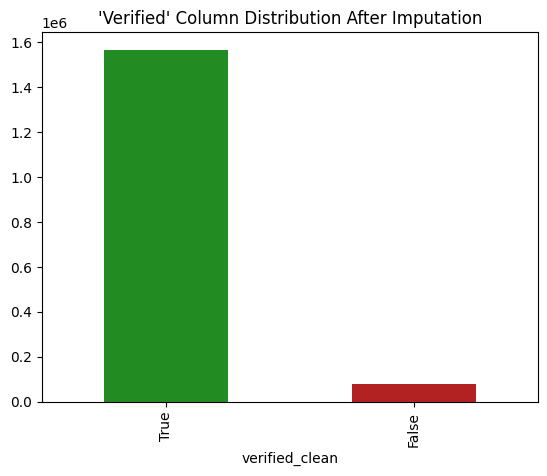

In [15]:
# Counting the occurrences of each unique value in the 'verified_clean' column
value_counts = automotive_df_working_dedup_filter['verified_clean'].value_counts()

# Defining colors for the bars
colors = ['forestgreen', 'firebrick']

# Creating a bar plot to visualize the distribution
value_counts.plot(kind='bar', color=colors)

# Adding title to the plot
plt.title("'Verified' Column Distribution After Imputation")

# Displaying the plot
plt.show()

### There are 1463684 missing values for votes which I will impute with 0

In [16]:
# Data treatment
# Vote imputation

# Imputing missing values with 0 
automotive_df_working_dedup_filter["vote_clean"] = automotive_df_working_dedup_filter["vote"].fillna(0)

# Checking the imputation
print(automotive_df_working_dedup_filter['vote_clean'].isnull().sum())  # Should be 0 after imputation

0


### There are 253 missing values for reviewerName which I will impute with "Unknown"

In [17]:
# Data treatment
# reviewer name imputation

# Imputing missing values with 0
automotive_df_working_dedup_filter["reviewerName_clean"] = automotive_df_working_dedup_filter["reviewerName"].fillna("UnKnown")

# Checking the imputation
print(automotive_df_working_dedup_filter['reviewerName_clean'].isnull().sum())  # Should be 0 after imputation

0


### There are 887 missing values for reviewText which we will simply drop

In [18]:
# Data treatment
# reviewText imputation
# There are 351 missing values in reviewText and hence, these records will be excluded. We are excluding because it is neglible

automotive_df_working_dedup_filter = automotive_df_working_dedup_filter.dropna(subset=["reviewText"])
# Checking the imputation
print(automotive_df_working_dedup_filter['reviewText'].isnull().sum())  # Should be 0 after imputation.

0


### Dropping style column

In [19]:
automotive_df_working_dedup_filter.drop(columns=['style'], inplace=True)

### There are 351 missing values for summary which I will simply drop

In [20]:
# Data treatment
# summary imputation

automotive_df_working_dedup_filter = automotive_df_working_dedup_filter.dropna(subset = ["summary"])

print(automotive_df_working_dedup_filter['summary'].isnull().sum())  # Should be 0 after imputation

0


### Dropping style column as this is not requrired

In [21]:
# Data treatment
# summary imputation

automotive_df_working_dedup_filter = automotive_df_working_dedup_filter.dropna(subset = ["summary"])

print(automotive_df_working_dedup_filter['summary'].isnull().sum())  # Should be 0 after imputation

0


### Data treatment for URL

In [22]:
# Data treatment
# Image URL availability

# Defining a regular expression for URL validation
# Observed from the data that non-null values have https pattern
url_regex = r"https?://\S+"  

# Creating a new column with flag based on URL presence
automotive_df_working_dedup_filter['image_available'] = automotive_df_working_dedup_filter['image'].apply(lambda x: 
                                                                                            bool(re.match(url_regex, str(x))))
# Check
automotive_df_working_dedup_filter.tail(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,reviewTime_cleaned,review_year,review_month,review_day,verified_clean,vote_clean,reviewerName_clean,image_available
1711517,5,True,"08 24, 2018",A1MJUNTX7CTR5U,B01HJI17Y8,JKPA,Way better than stock. Nice bright and white. ...,"NICE, BRIGHT AND WHITE",1535068800,NaN,['https://images-na.ssl-images-amazon.com/imag...,2018-08-24,2018,8,24,True,0,JKPA,False
1711518,5,True,"06 26, 2018",AF67UV2T2TFWB,B01HJI17Y8,DDraper,Great product fast shipping and awesome commun...,Five Stars,1529971200,NaN,NaN,2018-06-26,2018,6,26,True,0,DDraper,False


In [23]:
#Verifying columns
automotive_df_working_dedup_filter.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'reviewerName_clean',
       'image_available'],
      dtype='object')

## Creating the dependent variable - helpfulness. First I clean votes

In [24]:
automotive_df_working_dedup_filter.dtypes
# vote_clean is a string, needs to be converted to numeric

# Converting the 'vote_clean' column from string to numeric, handling errors by coercing invalid parsing to NaN
automotive_df_working_dedup_filter["vote_clean"] = pd.to_numeric(automotive_df_working_dedup_filter["vote_clean"], 
                                                                 errors='coerce')

In [25]:
# Generating descriptive statistics for numeric columns
automotive_df_working_dedup_filter.describe()

,overall,unixReviewTime,reviewTime_cleaned,review_year,review_month,review_day,vote_clean
count,1.640889e+06,1.640889e+06,1640889,1.640889e+06,1.640889e+06,1.640889e+06,1.640887e+06
mean,4.459528e+00,1.455920e+09,2016-02-19 22:10:41.633163264,2.015645e+03,6.422868e+00,1.573266e+01,6.211586e-01
min,1.000000e+00,1.262304e+09,2010-01-01 00:00:00,2.010000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,1.426291e+09,2015-03-14 00:00:00,2.015000e+03,3.000000e+00,8.000000e+00,0.000000e+00
50%,5.000000e+00,1.461629e+09,2016-04-26 00:00:00,2.016000e+03,6.000000e+00,1.600000e+01,0.000000e+00
75%,5.000000e+00,1.491437e+09,2017-04-06 00:00:00,2.017000e+03,9.000000e+00,2.300000e+01,0.000000e+00
max,5.000000e+00,1.538525e+09,2018-10-03 00:00:00,2.018000e+03,1.200000e+01,3.100000e+01,9.900000e+02
std,1.055950e+00,4.707623e+07,NaN,1.530443e+00,3.426832e+00,8.814529e+00,5.017202e+00


In [26]:
#displaying top 5 rows
automotive_df_working_dedup_filter.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,reviewTime_cleaned,review_year,review_month,review_day,verified_clean,vote_clean,reviewerName_clean,image_available
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN,2015-05-01,2015,5,1,False,0.0,Goldengate,False
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN,2018-04-19,2018,4,19,True,0.0,noe,False


In [27]:
# Displaying the data type of the 'vote_clean' column
automotive_df_working_dedup_filter['vote_clean'].dtype

dtype('float64')

In [28]:
# Checking for non-numeric values after conversion
non_numeric_count = automotive_df_working_dedup_filter["vote_clean"].isna().sum()
# Printing a warning message if there are non-numeric values present after conversion
if non_numeric_count > 0:
    print(f"Warning: {non_numeric_count} non-numeric values in vote_clean after conversion")

### There are 2 non numeric(nan) values in vote_clean

In [29]:
automotive_df_working_dedup_filter["vote_clean"].unique()

array([  0.,   2.,   3.,   7.,  10.,  88., 134.,  28.,   4.,   6.,  36.,
         9.,   5.,  11.,  16.,  15.,  12.,  24., 131.,   8.,  58.,  23.,
        13.,  14.,  30.,  21.,  33.,  19.,  35.,  18.,  20.,  32.,  99.,
        40.,  42.,  37., 104.,  34.,  29.,  22.,  27.,  26., 145.,  78.,
        53., 216.,  17.,  39.,  68.,  82.,  51., 106.,  44.,  63.,  31.,
        67.,  48.,  50.,  46.,  45.,  38., 329.,  64.,  65., 280.,  25.,
        49., 275.,  54.,  41.,  47.,  73.,  57., 174.,  59., 330.,  61.,
        87.,  74.,  43., 164.,  69., 122., 196.,  81., 302.,  76., 166.,
        52.,  80., 147., 111.,  95., 100.,  71., 596., 115., 199., 188.,
       117., 133., 167., 242., 504.,  89.,  66.,  86.,  60.,  93., 627.,
       153., 206., 252., 121., 101.,  92.,  75., 113.,  77., 324.,  90.,
       123.,  94., 108., 141., 105., 638.,  56.,  83.,  70., 449., 159.,
       158., 128., 170., 407., 149.,  55., 129., 126., 130., 112.,  85.,
       110., 120., 103., 198., 132., 152., 343., 66

In [30]:
# There are only 2 values which are nan and it is convenient to drop these values.
automotive_df_working_dedup_filter = automotive_df_working_dedup_filter.dropna(subset=["vote_clean"])

In [31]:
#checking the shape of dataframe
automotive_df_working_dedup_filter.shape

(1640887, 19)

In [32]:
#verifying if nan is gone
automotive_df_working_dedup_filter["vote_clean"].unique()

array([  0.,   2.,   3.,   7.,  10.,  88., 134.,  28.,   4.,   6.,  36.,
         9.,   5.,  11.,  16.,  15.,  12.,  24., 131.,   8.,  58.,  23.,
        13.,  14.,  30.,  21.,  33.,  19.,  35.,  18.,  20.,  32.,  99.,
        40.,  42.,  37., 104.,  34.,  29.,  22.,  27.,  26., 145.,  78.,
        53., 216.,  17.,  39.,  68.,  82.,  51., 106.,  44.,  63.,  31.,
        67.,  48.,  50.,  46.,  45.,  38., 329.,  64.,  65., 280.,  25.,
        49., 275.,  54.,  41.,  47.,  73.,  57., 174.,  59., 330.,  61.,
        87.,  74.,  43., 164.,  69., 122., 196.,  81., 302.,  76., 166.,
        52.,  80., 147., 111.,  95., 100.,  71., 596., 115., 199., 188.,
       117., 133., 167., 242., 504.,  89.,  66.,  86.,  60.,  93., 627.,
       153., 206., 252., 121., 101.,  92.,  75., 113.,  77., 324.,  90.,
       123.,  94., 108., 141., 105., 638.,  56.,  83.,  70., 449., 159.,
       158., 128., 170., 407., 149.,  55., 129., 126., 130., 112.,  85.,
       110., 120., 103., 198., 132., 152., 343., 66

### Cleaning for text columns

### There were no nan values for summary and reviewtext so next cells can be skipped

In [33]:
# Checking for NaN values in summary
summary_nan_count = automotive_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary after conversion")


In [34]:
# NaN will be dropped in the summary
automotive_df_working_dedup_filter = automotive_df_working_dedup_filter.dropna(subset=["summary"]) 

In [35]:
# Checking for NaN values in # reviewText
reviewText_nan_count = automotive_df_working_dedup_filter["reviewText"].isna().sum()
if reviewText_nan_count > 0:
    print(f"Warning: {reviewText_nan_count} nan values in review Text")


In [36]:
# NaN will be dropped in the reviewText
automotive_df_working_dedup_filter = automotive_df_working_dedup_filter.dropna(subset=["reviewText"]) 

In [37]:
automotive_df_working_dedup_filter.shape

(1640887, 19)

### Distribution of Votes Linear and Logarithm Scale

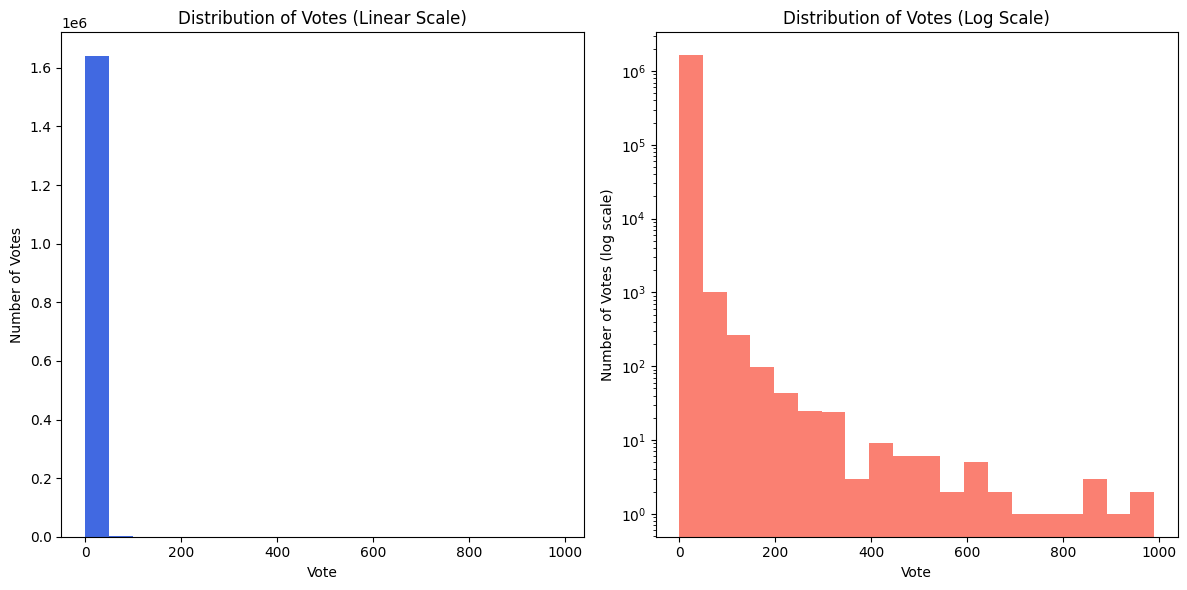

In [38]:
# Creating a figure and axis objects for subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Distribution of votes (linear scale)
axs[0].hist(automotive_df_working_dedup_filter['vote_clean'], bins=20, color='royalblue')
axs[0].set_xlabel("Vote")
axs[0].set_ylabel("Number of Votes")
axs[0].set_title("Distribution of Votes (Linear Scale)")

# Subplot 2: Distribution of votes (log scale)
axs[1].hist(automotive_df_working_dedup_filter['vote_clean'], bins=20, color='salmon', log=True)
axs[1].set_xlabel("Vote")
axs[1].set_ylabel("Number of Votes (log scale)")
axs[1].set_title("Distribution of Votes (Log Scale)")

# Adjust layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
# Cross tab of vote counts
# Cross tabulation of vote counts
print(automotive_df_working_dedup_filter['vote_clean'].value_counts().sort_index(ascending=True))

vote_clean
0.0      1460729
2.0        72368
3.0        34784
4.0        19816
5.0        12250
          ...   
849.0          1
874.0          1
917.0          1
966.0          1
990.0          1
Name: count, Length: 302, dtype: int64


### Creating our dependent variable 'helpfulness_binary' with the following conditions

In [40]:
# 1 if Votes > 0 and verified is True
# 0 otherwise
automotive_df_working_dedup_filter['helpfulness_binary'] = automotive_df_working_dedup_filter[['vote_clean', 'verified_clean']].apply(lambda x:
                                                        1 if x['vote_clean'] > 0 
                                                        and x['verified_clean'] else 0, 
                                                        axis=1)

# Checking counts of 0 and 1
print(automotive_df_working_dedup_filter['helpfulness_binary'].value_counts().sort_index(ascending=True))


helpfulness_binary
0    1474453
1     166434
Name: count, dtype: int64


### Distribution of Helpfulness Binary

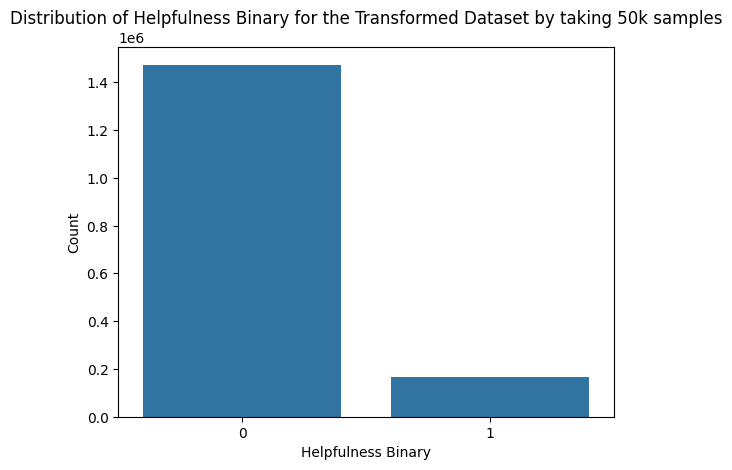

In [41]:
# Plotting the distribution of 'helpfulness_binary'
sns.countplot(x='helpfulness_binary', data=automotive_df_working_dedup_filter)
plt.title('Distribution of Helpfulness Binary for the Transformed Dataset by taking 50k samples')
plt.xlabel('Helpfulness Binary')
plt.ylabel('Count')
plt.show()

### Calculating the percentage of helpfulness binary

In [42]:
# Calculating the total number of entries
total_entries = len(automotive_df_working_dedup_filter)

# Calculating the count 'helpfulness_binary'
helpfulness_counts = automotive_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculating the percentage 
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 10.14292879399983
Percentage of Not helpfulness 89.85707120600017


#### Helpfulness is 10.1% and 89.9% is not helpful percentage

### Now cleaned data has 1.64 millions record performing data transformation on this would be computationally expensive so I'll use stratified sampling on the pre-processed dataset

In [43]:
# Stratified sampling
def stratified_sampling(data, sample_size, feature_list):

    strata_counts = data.groupby(feature_list).size()

    # Calculating target sample sizes for each stratum (proportional to population)
    total_count = strata_counts.sum()
    strata_sample_sizes = (strata_counts / total_count * sample_size).round().astype(int)

    # Sample calculation of reviews from each stratum
    sampled_reviews = []
    for stratum, size in strata_sample_sizes.items():
        # Checking if sample size for the stratum is 0
        if size == 0:
            continue  # Skip sampling for this stratum

        stratum_reviews = data[data[feature_list].eq(stratum).all(axis=1)]
        # Adjusting sample size if it's larger than the number of items available in the stratum
        # taking max may lead to oversampling
        # min will be more accurate
        size = min(size, len(stratum_reviews))
        # Random sampling within the stratum
        # replace=False ensures that same datapoint isn't sampled twice
        sampled_stratum = stratum_reviews.sample(n=size, replace=False)
        sampled_reviews.append(sampled_stratum)

    # Concatenating sampled reviews
    if sampled_reviews:
        sampled_df = pd.concat(sampled_reviews)
    else:
        sampled_df = pd.DataFrame(columns=data.columns)  # Creating an empty DataFrame if no samples are selected

    return sampled_df

In [44]:
#verifying the data types
automotive_df_working_dedup_filter.dtypes

overall                        int64
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
vote                          object
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
reviewerName_clean            object
image_available                 bool
helpfulness_binary             int64
dtype: object

In [45]:
#verifying the shape
automotive_df_working_dedup_filter.shape

(1640887, 20)

### Since our data is huge we are doing stratified sampling on 50,000 of the pre-processed data

In [46]:
# Specifying the strata features
strata_feature_list = ["helpfulness_binary", # dependent variable as strata to ensure class balance remains
                       # month and year as strata to ensure sample is representative of seasonality and review age
                       "review_year",
                       "review_month",
                       # image availability strata to ensure sample is representative of overall population
                       "image_available" ]
                       # asin is computationally expensive and is not required

# Specifying total sample volume
final_data_sample_size = 50000

#creating sampled dataframe
automotive_df_working_dedup_filter_sample = stratified_sampling(automotive_df_working_dedup_filter,
                                                              final_data_sample_size, strata_feature_list)

In [47]:
#checking the records
automotive_df_working_dedup_filter_sample.shape

(50002, 20)

In [48]:
# Checking counts of helpfulness
print(automotive_df_working_dedup_filter_sample['helpfulness_binary'].value_counts().sort_index(ascending=True))

helpfulness_binary
0    44928
1     5074
Name: count, dtype: int64


### There are helpfulness_binary 44928 not helpful records and 5074 helpful records in the sampled dataset

### Distribution of Helpfulness Binary for Stratified sampled 50k 

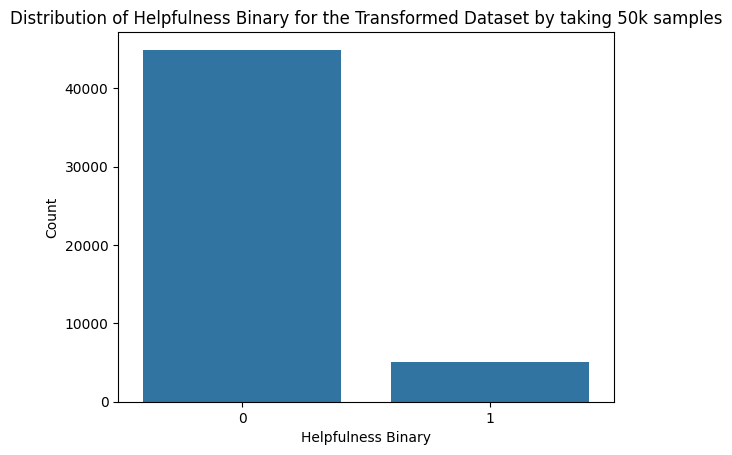

In [49]:
# Plot the distribution of 'helpfulness_binary'
sns.countplot(x='helpfulness_binary', data=automotive_df_working_dedup_filter_sample)
plt.title('Distribution of Helpfulness Binary for the Transformed Dataset by taking 50k samples')
plt.xlabel('Helpfulness Binary')
plt.ylabel('Count')
plt.show()

### After stratified sampling checking if the distribution of helpfulness is same as the population

In [50]:
# Calculating the total number of entries for sample data
total_entries = len(automotive_df_working_dedup_filter_sample)

# Calculating the count'helpfulness_binary' for sample data
helpfulness_counts = automotive_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Calculating the percentage of each category for sample data
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages for sample data
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 10.147594096236151
Percentage of Not helpfulness 89.85240590376385


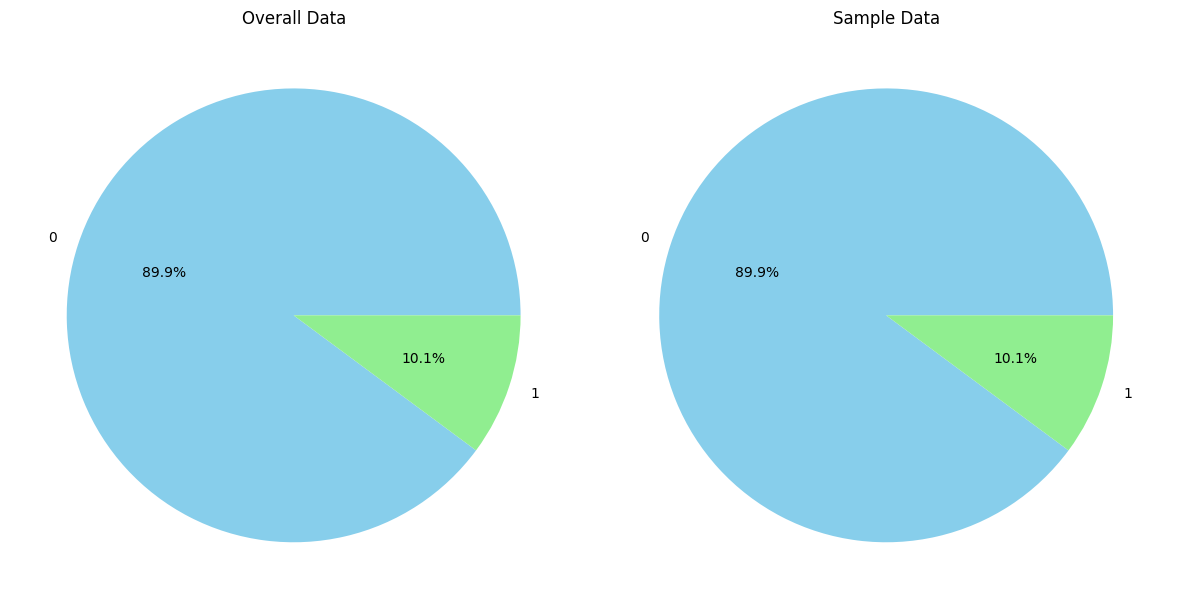

In [51]:
# Calculate counts for each category in the overall Data
overall_counts = automotive_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculate counts for each category in the sample Data
sample_counts = automotive_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Pie Chart
plt.figure(figsize=(12, 6))

# Plot pie chart for the overall Data
plt.subplot(1, 2, 1)
plt.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Overall Data')

# Plot pie chart for the sample Data
plt.subplot(1, 2, 2)
plt.pie(sample_counts, labels=sample_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Sample Data')

plt.tight_layout()
plt.show()

### Concluded that sampled data is same as overall population

### Plotting Word distributions and counts of non-word characters in the review text before cleaning process.

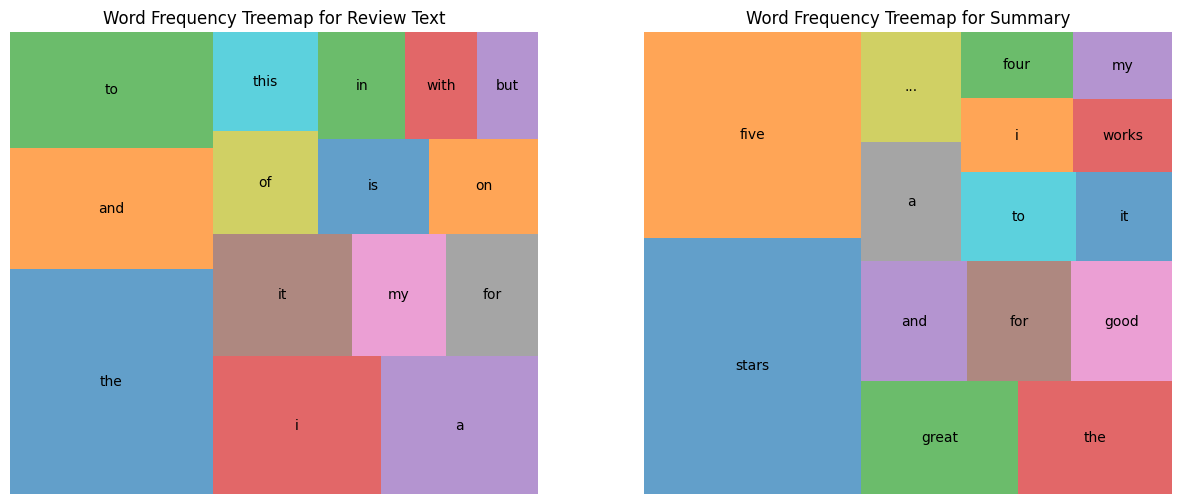

In [53]:
# Setting text and summary parameters
review_text = automotive_df_working_dedup_filter_sample["reviewText"]
summary_text = automotive_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

# Define custom colors for the treemap
custom_colors = sns.color_palette('tab10', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_colors, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text')

# Create treemap for summary
squarify.plot(sizes=summary_sizes, label=summary_labels, alpha=0.7, color=custom_colors, ax=axes[1])
axes[1].set_title('Word Frequency Treemap for Summary')

# Turn off axis for both plots
for ax in axes:
    ax.axis('off')

# Show plots
plt.show()


### From the above chart, we can see there are lot of irrelevent words, which we call them as stop words

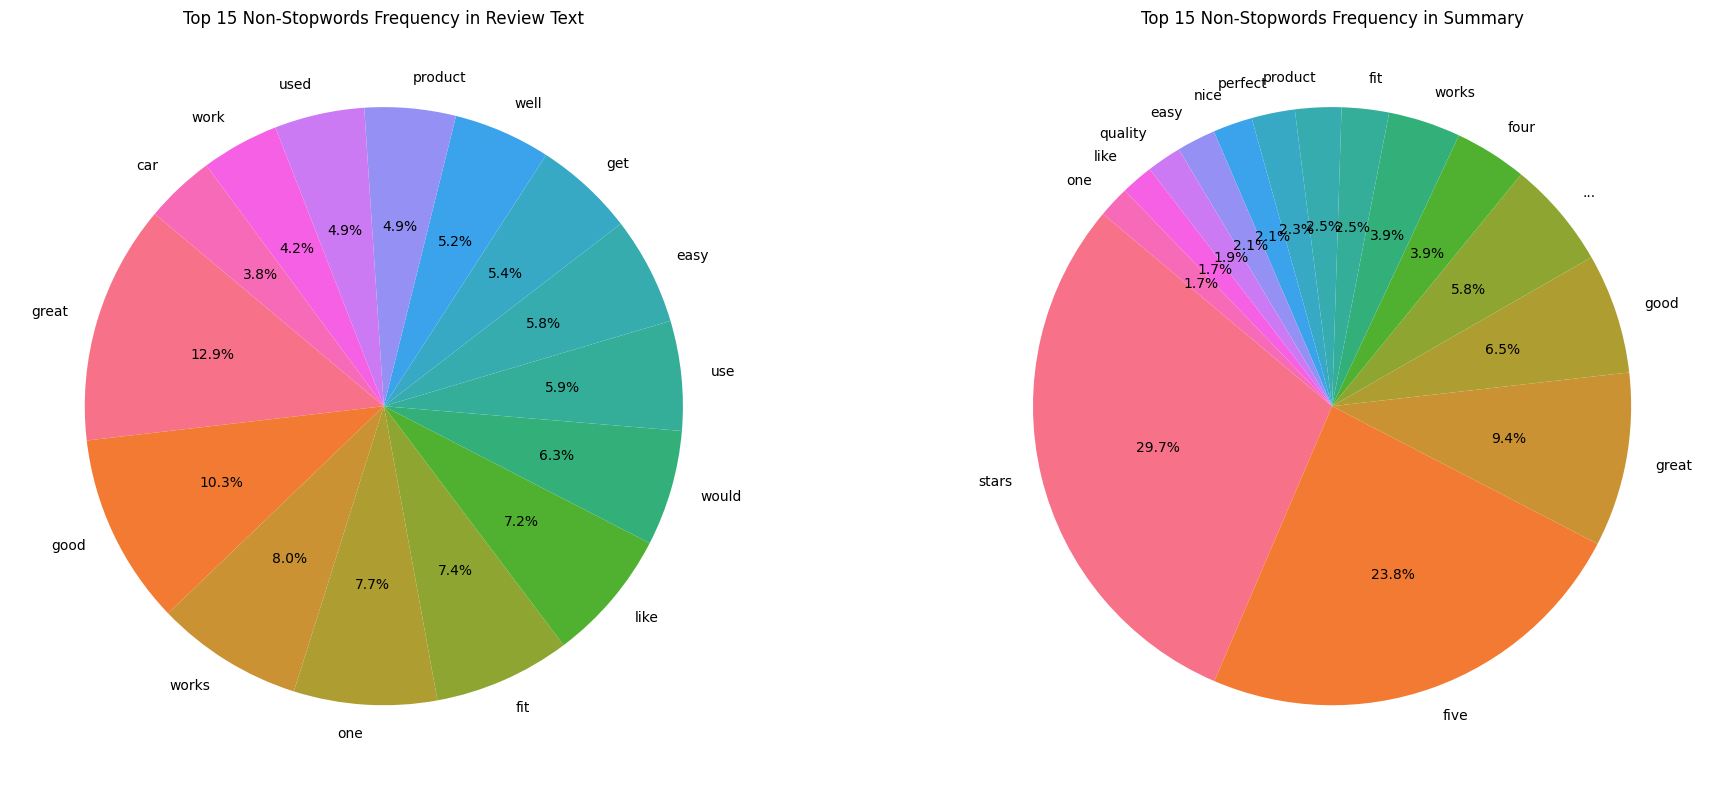

In [54]:
# Setting text and summary parameters
review_text = automotive_df_working_dedup_filter_sample["reviewText"]
summary_text = automotive_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Remove stopwords from summary
summary_words = [word for word in summary_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

custom_palette = sns.color_palette('husl', n_colors=top_n)

# Create pie chart for review text
plt.figure(figsize=(20, 8
                    ))
plt.subplot(1, 2, 1)
plt.pie(review_sizes, labels=review_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Review Text')

# Create pie chart for summary
plt.subplot(1, 2, 2)
plt.pie(summary_sizes, labels=summary_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Summary')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

### Based on the above two visualisations., the highest count for words is for the stop words as compared to the non-stop words in both review text and summary. Therefore, it is important to remove the stop words, and later on shall see visualisations post removal of stop words.

/tmp/ipykernel_17378/1333766021.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_17378/1333766021.py:52: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




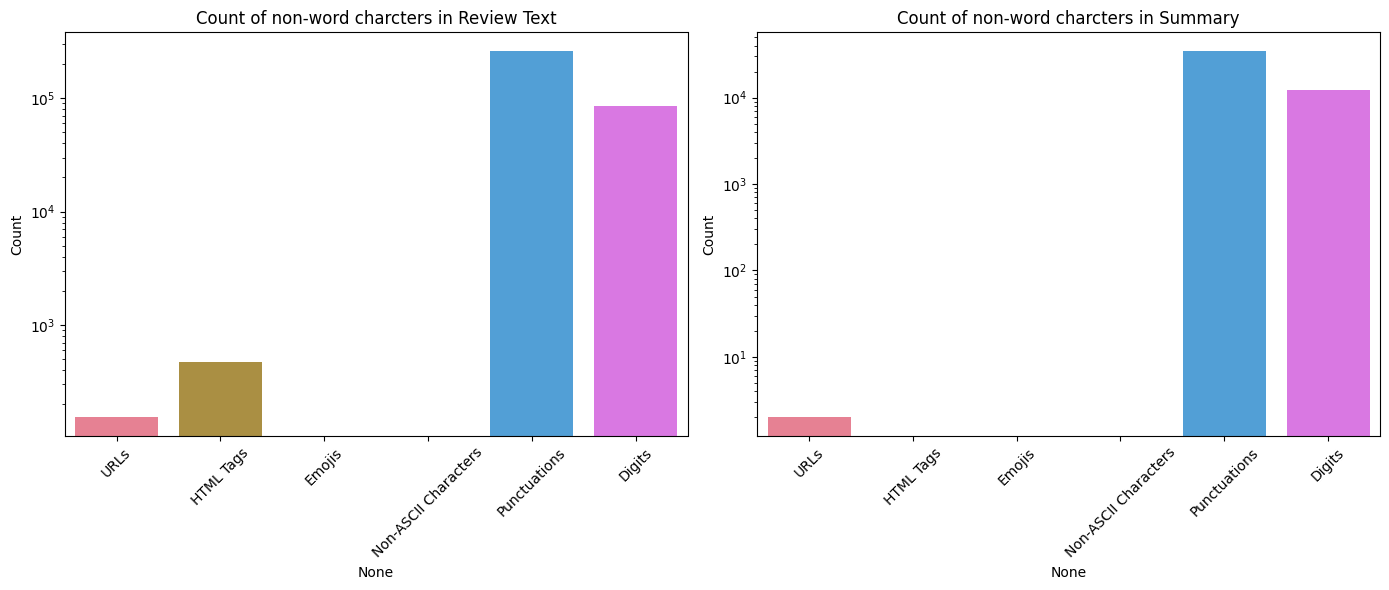

In [55]:
# Setting text and summary parameters
review_text = automotive_df_working_dedup_filter_sample["reviewText"]
summary_text = automotive_df_working_dedup_filter_sample["summary"]

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
html_tag_pattern = r'<.*?>'
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]+'
non_ascii_pattern = r'[^\x00-\x7F]+'
punctuation_pattern = r'[^\w\s]'
digit_pattern = r'\d'

# Function to count occurrences of patterns in text
def count_occurrences(text, pattern):
    return len(re.findall(pattern, text))

# Count occurrences of patterns in review text
review_counts = {
    "URLs": count_occurrences(' '.join(review_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(review_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(review_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(review_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(review_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(review_text), digit_pattern)
}

# Count occurrences of patterns in summary
summary_counts = {
    "URLs": count_occurrences(' '.join(summary_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(summary_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(summary_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(summary_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(summary_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(summary_text), digit_pattern)
}

# Convert counts to DataFrame for plotting
review_counts_df = pd.DataFrame.from_dict(review_counts, orient='index', columns=['Count'])
summary_counts_df = pd.DataFrame.from_dict(summary_counts, orient='index', columns=['Count'])


# Plot counts for review text
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=review_counts_df.index, y='Count', data=review_counts_df, palette='husl')
plt.title('Count of non-word charcters in Review Text')
plt.xticks(rotation=45)
plt.yscale('log')

# Plot counts for summary
plt.subplot(1, 2, 2)
sns.barplot(x=summary_counts_df.index, y='Count', data=summary_counts_df, palette='husl')
plt.title('Count of non-word charcters in Summary')
plt.xticks(rotation=45)
plt.yscale('log')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


### From the above visualization there are a lot of non-word characters in the review text and columns like emojis, numeric characters, punctuations etc. They are not useful for our modelling. Cleaning them before feature engineering.

### Data Transformation and Feature Engineering 

#### 1) Review title (summary) metadata: 
1a) # words in title 

1b) # length of original title

1c) Title sentiment 

1d) Unique word count 

1e) Emoji & non-ASCII character count 

1f) Term frequency/TFIDF of the cleaned title with prefix of title if summary is not similar to text (might be tricky to do)

#### 2) Review text (reviewText) metadata: 
2a) # words in review 

2b) # length of original review 

2c) Review sentiment 

2d) Unique word count 

2e) URL availability inside reviewtext 

2f) Stop word count  

2g) Emoji & non-ASCII character count 

#### 3) Age of review: (end of 2018 - review posted date) = review age in days

#### 4) Review text cleaning: 
4a) convert reviewtext to lowercase, remove double spaces, punctuations, numbers 

4b) Expand I've, We're to I have, We have etc. 

4c) Remove URLs, stopwords (standard and custom), non-ASCII characters, emojis and other non-printable characters 

4d) Remove sparse words 

4e) Lemmatization 

4f) n-grams: Check for top unigrams and bigrams - study distributions, is there a pareto? 

In [56]:
# Function definitions

# Function for number of words in input text
def num_words(text):
    return len(word_tokenize(text))

# Function to get length of input text
def text_length(text):
    return len(text)

# Sentiment polarity
# <0 indicates negative sentiment
# 0 indicates netural
# >0 indicates positive sentiment
def text_sentiment(title):
    blob = TextBlob(title)
    return blob.sentiment.polarity

# Function to get count of unique words in the input text
def unique_word_count(text):
    return len(set(word_tokenize(text)))

# If UNICODE_EMOJI isn't getting installed, use this version of the function
# This uses a regex pattern to capture non-alphanumeric characters
def emoji_and_non_ascii_count(text):
    emoji_pattern = r"[^a-zA-Z0-9\s+\.\!]"
    return len(re.findall(emoji_pattern, text))

# Function to count the number of URLs inside the input text
def url_count(text):
    url_pattern = r"http[s]?://\S+"  # Regular expression for URLs
    return len(re.findall(url_pattern, text))

# Function to count the number of English stopwords in the input text
def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return sum(word in stop_words for word in words)


### Creating features 1a - 1f

In [57]:
# 1a: Number of words in the title
automotive_df_working_dedup_filter_sample['num_words_review_title'] = automotive_df_working_dedup_filter_sample['summary'].apply(num_words)
# 1b. length of original title
automotive_df_working_dedup_filter_sample['title_length'] = automotive_df_working_dedup_filter_sample['summary'].apply(text_length)

# 1d: Sentiment polarity 
automotive_df_working_dedup_filter_sample['title_sentiment'] = automotive_df_working_dedup_filter_sample['summary'].apply(text_sentiment)

# 1e: Unique word count
automotive_df_working_dedup_filter_sample['unique_word_count_title'] = automotive_df_working_dedup_filter_sample['summary'].apply(unique_word_count)

# 1f: Emoji & non-ASCII character count
automotive_df_working_dedup_filter_sample['emoji_non_ascii_count_title'] = automotive_df_working_dedup_filter_sample['summary'].apply(emoji_and_non_ascii_count)


# Check
automotive_df_working_dedup_filter_sample.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,verified_clean,vote_clean,reviewerName_clean,image_available,helpfulness_binary,num_words_review_title,title_length,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title
18214,2,True,"01 27, 2010",A1YWKJIF7784WJ,B00029WRKU,sierra adventurer,Good quality product but does not fasten secur...,Floppy Mirror,1264550400,NaN,...,True,0.0,sierra adventurer,False,0,2,13,0.0,2,0
365664,5,True,"01 10, 2010",A11758N6N9KEK,B000VAXG78,Akram,"OEM quality part, fit without any modification...",That exsactly what I want,1263081600,NaN,...,True,0.0,Akram,False,0,5,25,0.0,5,0


### Creating features 2a - 2g

In [58]:
# 2a: Number of words in the review
automotive_df_working_dedup_filter_sample['num_words_review_text'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(num_words)

# 2b. length of original review
automotive_df_working_dedup_filter_sample['review_length'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(text_length)

# 2c: Sentiment polarity of review 
automotive_df_working_dedup_filter_sample['review_sentiment'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(text_sentiment)

# 2d: Unique word count
automotive_df_working_dedup_filter_sample['unique_word_count_review'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(unique_word_count)

# 2e: URL count inside reviewtext
automotive_df_working_dedup_filter_sample['url_count_review'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(url_count)

# 2f: Stop word count 
automotive_df_working_dedup_filter_sample['stop_word_count_review'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(stopword_count)

# 2g: Emoji & non-ASCII character count 
automotive_df_working_dedup_filter_sample['emoji_non_ascii_count_review'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(emoji_and_non_ascii_count)

automotive_df_working_dedup_filter_sample.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title,num_words_review_text,review_length,review_sentiment,unique_word_count_review,url_count_review,stop_word_count_review,emoji_non_ascii_count_review
18214,2,True,"01 27, 2010",A1YWKJIF7784WJ,B00029WRKU,sierra adventurer,Good quality product but does not fasten secur...,Floppy Mirror,1264550400,NaN,...,0.0,2,0,26,130,0.55000,24,0,9,1
365664,5,True,"01 10, 2010",A11758N6N9KEK,B000VAXG78,Akram,"OEM quality part, fit without any modification...",That exsactly what I want,1263081600,NaN,...,0.0,5,0,25,128,0.10875,23,0,8,2


### 3) Age of review: (end of 2018 - review posted date) = review age in days

In [59]:
# Calculating the end date of 2018 as the reference date since the dataset is as of 2018
end_of_2018 = datetime(2018, 12, 31)

# Converting datetime64[ns] to pandas datetime
if pd.api.types.is_datetime64_dtype(automotive_df_working_dedup_filter_sample['reviewTime_cleaned']):
    automotive_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(automotive_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Calculating the age in days
automotive_df_working_dedup_filter_sample['review_age_days'] = (end_of_2018 - automotive_df_working_dedup_filter_sample['reviewTime_cleaned']).dt.days


In [60]:
# Check
automotive_df_working_dedup_filter_sample.shape

(50002, 33)

### 4: Review Text cleaning

### Defining a master function that will do the following for a provided input text:

In [61]:
# 4: Text cleaning

# Defining a master function that will do the following for a provided input text:
# 4a) Lowercase and remove double spaces
# 4b) Expand contractions
# 4c) Remove unwanted characters, numbers, punctuations
# 4d) Resolving acronyms and abbreviations 

def remove_urls_html_tags(text):
    # Removes URLs and HTML tags from text
    pattern = r"https?://\S+|www\.\S+|<.*?>"
    return re.sub(pattern, "", text, flags=re.MULTILINE)

def expand_contractions(text):
    # Expands contractions in text
    return contractions.fix(text)

def remove_non_ascii_and_emojis(text):
    #Removes non-ASCII characters and emojis from text
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', re.sub(r'[^\x00-\x7F]+', r'', text))

def remove_punctuations_and_digits(text):
    # Removes punctuations and digits from text
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translation_table)

def expand_acronyms_and_abbreviations(text):
    # Expands acronyms and abbreviations in text (add more as required)."""
    acronyms_abbrs = {
        "tbh": "to be honest",
        "2mw": "tomorrow",
        "lol": "laugh out loud",
        "fyi": "for your information",
        "acct": "account",
        "adih": "another day in hell",
        "afaic": "as far as i am concerned",
        "afaict": "as far as i can tell",
        "afaik": "as far as i know",
        "afair": "as far as i remember",
        "afk": "away from keyboard",
        "gr8": "great",
        "omg": "oh my god",
        "omw": "on my way"
    }

    for acronym, full_form in acronyms_abbrs.items():
        text = text.replace(acronym, full_form)

    return text

def remove_stopwords(text):
    # Removes stopwords from text (add custom stopwords to the list)
    custom_stopwords = ["amazon", "order", "also"]
    stop_words = stopwords.words("english") + custom_stopwords
    return " ".join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    # Lemmatizes text to its base form
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def clean_text_master_function(text):
    # Cleans text by performing various text cleaning steps
    text = text.lower()
    text = text.replace(" ", " ")  # Remove double spaces
    text = remove_urls_html_tags(text)
    text = remove_non_ascii_and_emojis(text)
    text = remove_punctuations_and_digits(text)
    text = expand_contractions(text)
    text = expand_acronyms_and_abbreviations(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

In [62]:
# Applying the cleaning function to the reviewText column
automotive_df_working_dedup_filter_sample['review_text_clean'] = automotive_df_working_dedup_filter_sample['reviewText'].apply(clean_text_master_function)

In [63]:
automotive_df_working_dedup_filter_sample['review_text_clean'].head(2)

18214     good quality product fasten securely rnr mirro...
365664    oem quality part fit without modification high...
Name: review_text_clean, dtype: object

In [64]:
automotive_df_working_dedup_filter_sample['review_text_clean'].shape

(50002,)

### Visualizing the data Post Cleaning and Stop word Removal

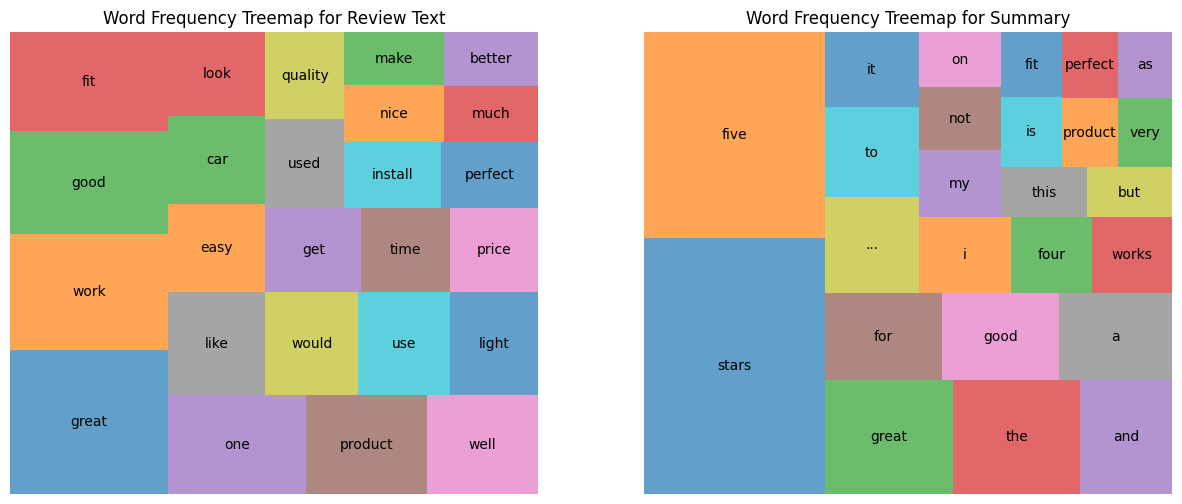

In [65]:
# Setting text and summary parameters
review_text = automotive_df_working_dedup_filter_sample["review_text_clean"]
summary_text = automotive_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 25
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

# Define custom colors for the treemap
custom_colors = sns.color_palette('tab10', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_colors, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text')

# Create treemap for summary
squarify.plot(sizes=summary_sizes, label=summary_labels, alpha=0.7, color=custom_colors, ax=axes[1])
axes[1].set_title('Word Frequency Treemap for Summary')

# Turn off axis for both plots
for ax in axes:
    ax.axis('off')

# Show plots
plt.show()

### As observed from the above chart that the stop words have been removed

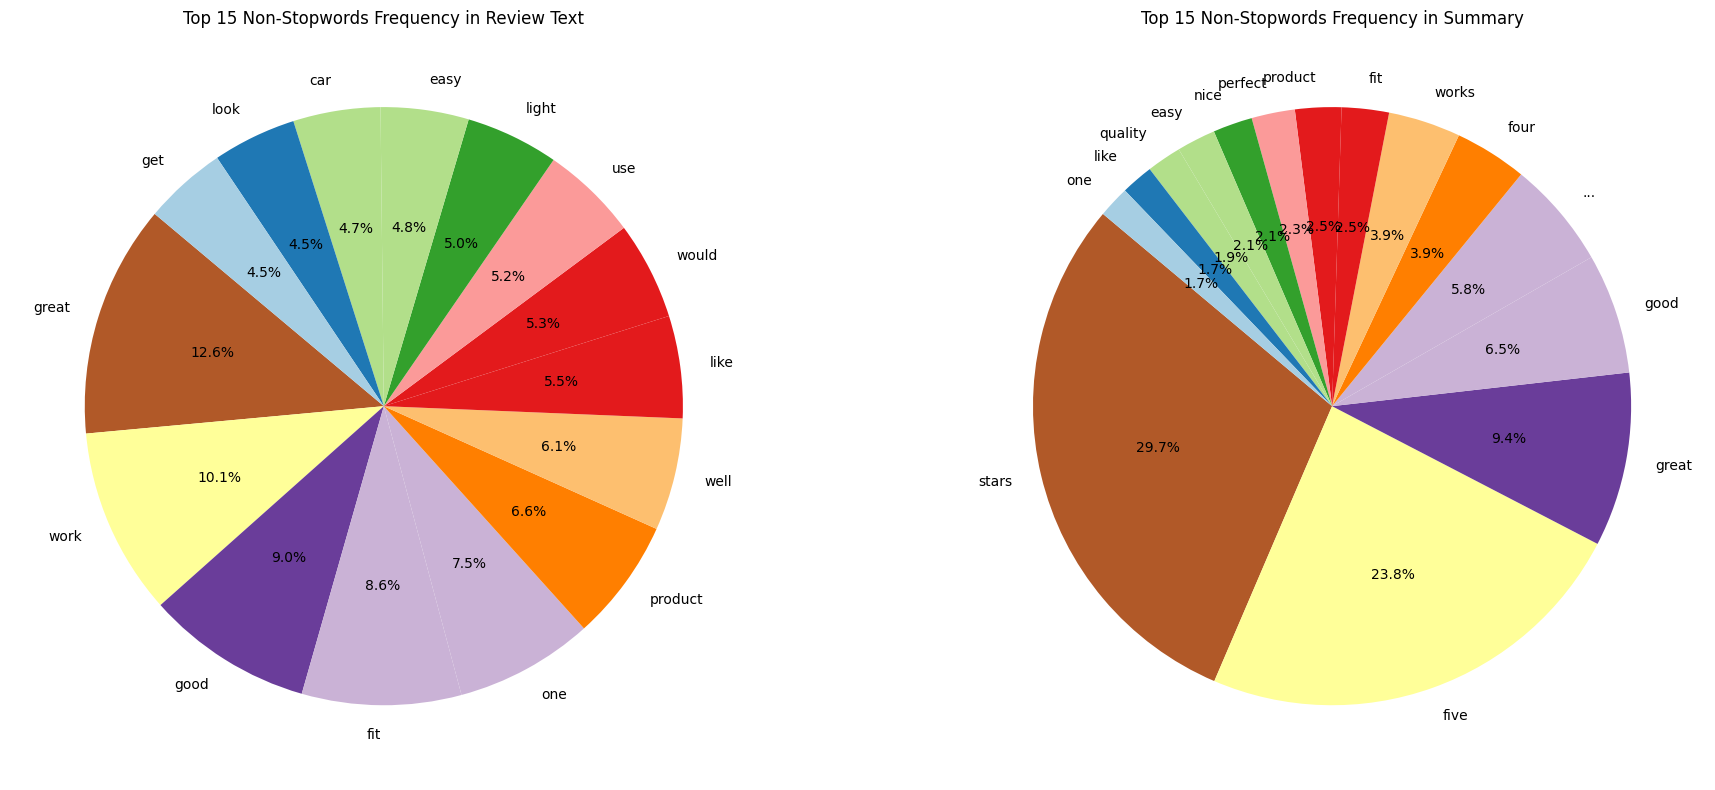

In [66]:
#Setting text and summary parameters
review_text = automotive_df_working_dedup_filter_sample["review_text_clean"]
summary_text = automotive_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Remove stopwords from summary
summary_words = [word for word in summary_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

custom_palette = sns.color_palette('Paired_r', n_colors=top_n)

# Create pie chart for review text
plt.figure(figsize=(20, 8
                    ))
plt.subplot(1, 2, 1)
plt.pie(review_sizes, labels=review_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Review Text')

# Create pie chart for summary
plt.subplot(1, 2, 2)
plt.pie(summary_sizes, labels=summary_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Summary')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

### The top 15 words are no longer stop words after cleaning

/tmp/ipykernel_17378/1243532839.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_17378/1243532839.py:52: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




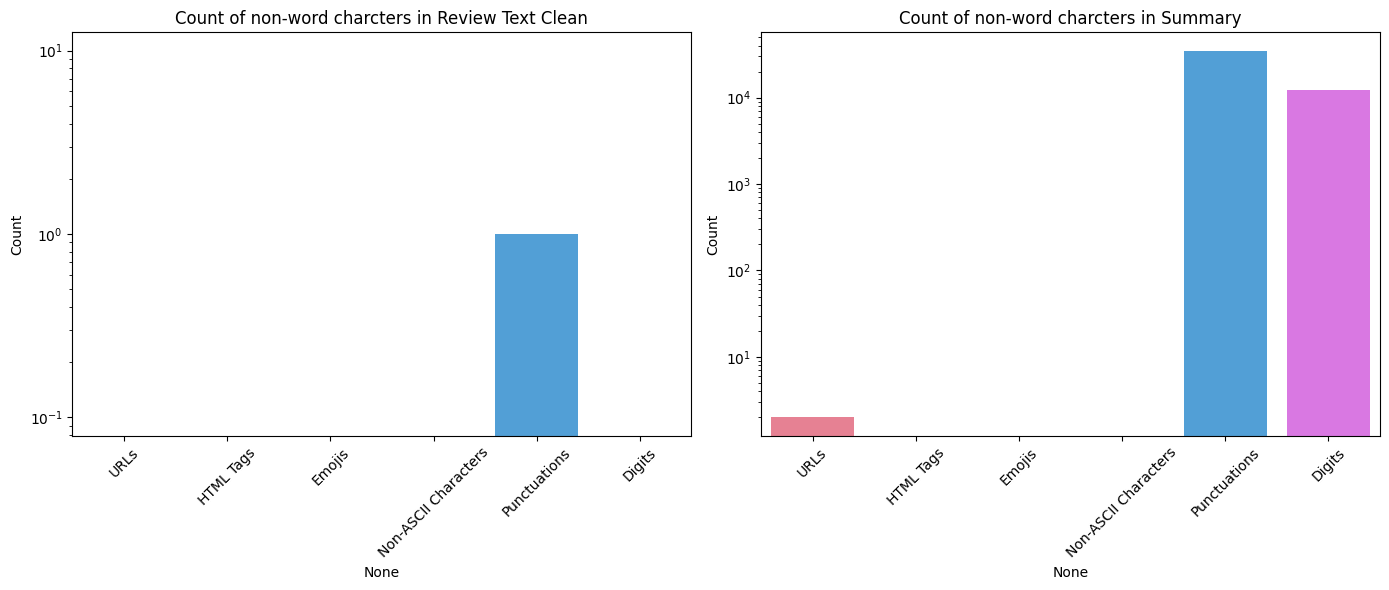

In [67]:
# Setting text and summary parameters
review_text = automotive_df_working_dedup_filter_sample["review_text_clean"]
summary_text = automotive_df_working_dedup_filter_sample["summary"]

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
html_tag_pattern = r'<.*?>'
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]+'
non_ascii_pattern = r'[^\x00-\x7F]+'
punctuation_pattern = r'[^\w\s]'
digit_pattern = r'\d'

# Function to count occurrences of patterns in text
def count_occurrences(text, pattern):
    return len(re.findall(pattern, text))

# Count occurrences of patterns in review text
review_counts = {
    "URLs": count_occurrences(' '.join(review_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(review_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(review_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(review_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(review_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(review_text), digit_pattern)
}

# Count occurrences of patterns in summary
summary_counts = {
    "URLs": count_occurrences(' '.join(summary_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(summary_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(summary_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(summary_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(summary_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(summary_text), digit_pattern)
}

# Convert counts to DataFrame for plotting
review_counts_df = pd.DataFrame.from_dict(review_counts, orient='index', columns=['Count'])
summary_counts_df = pd.DataFrame.from_dict(summary_counts, orient='index', columns=['Count'])


# Plot counts for review text
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=review_counts_df.index, y='Count', data=review_counts_df, palette='husl')
plt.title('Count of non-word charcters in Review Text Clean')
plt.xticks(rotation=45)
plt.yscale('log')

# Plot counts for summary
plt.subplot(1, 2, 2)
sns.barplot(x=summary_counts_df.index, y='Count', data=summary_counts_df, palette='husl')
plt.title('Count of non-word charcters in Summary')
plt.xticks(rotation=45)
plt.yscale('log')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

### As observed from the above visualizations, post cleaning, the stop words are gone from the Cleaned Review text. Cleaning was not performed on Summary column as it's not required to generate our features. The cleaned review text also does not have any URLs, html tags, digits, non-ascii characters or emojis. 

### Sentiment Analysis

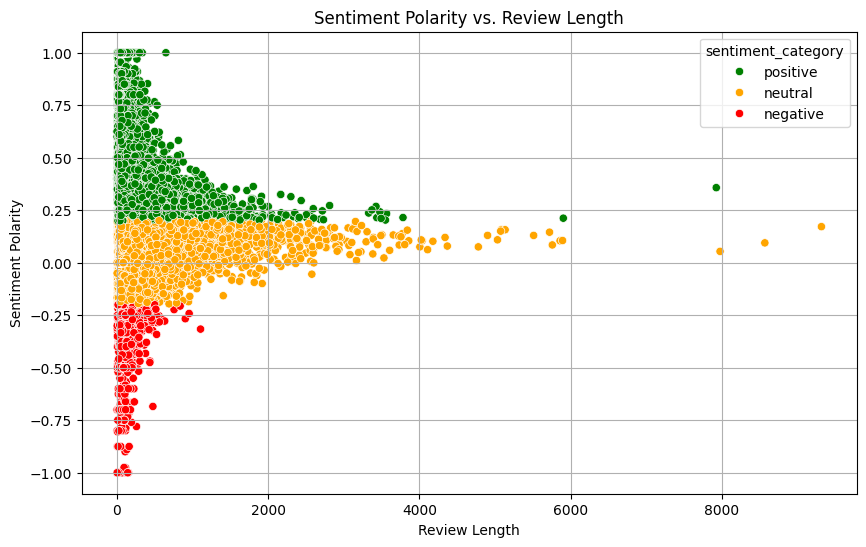

In [68]:
review_data = automotive_df_working_dedup_filter_sample  # Assuming you have a DataFrame containing review data

# Define thresholds for positive, negative, and neutral sentiment
positive_threshold = 0.2
negative_threshold = -0.2

# Function to categorize sentiment polarity based on thresholds
def categorize_sentiment(polarity):
    if polarity >= positive_threshold:
        return 'positive'
    elif polarity <= negative_threshold:
        return 'negative'
    else:
        return 'neutral'

# Categorize sentiment based on polarity thresholds
review_data['sentiment_category'] = review_data['review_sentiment'].apply(categorize_sentiment)

# Plot scatter plot of sentiment polarity vs. review length with color-coded polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=review_data, x='review_length', y='review_sentiment', hue='sentiment_category', palette={'positive': 'green', 'negative': 'red', 'neutral': 'orange'})
plt.title('Sentiment Polarity vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

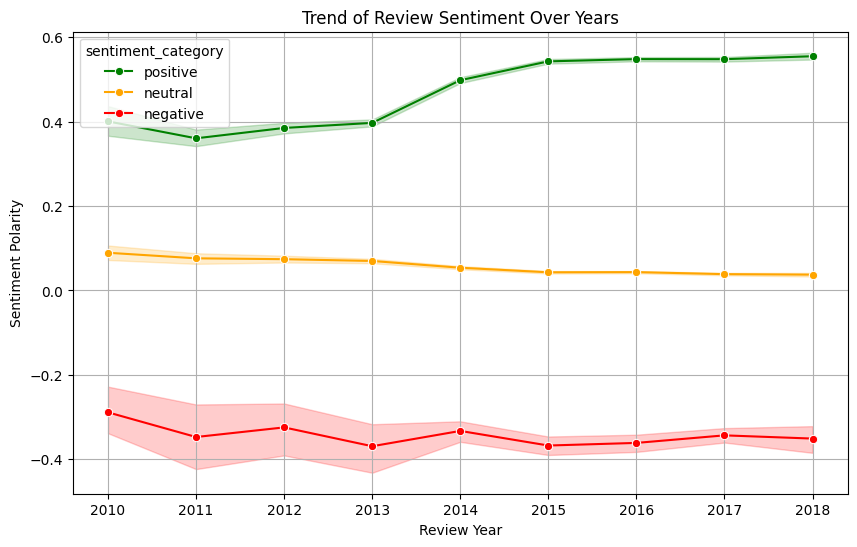

In [69]:
review_data = automotive_df_working_dedup_filter_sample  # Assuming you have a DataFrame containing review data

# Function to get sentiment category based on polarity
def get_sentiment_category(polarity):
    if polarity <= -0.2:
        return 'negative'
    elif polarity >= 0.2:
        return 'positive'
    else:
        return 'neutral'
    
# Define custom color palette
custom_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'orange'}

# Categorize sentiment polarity into positive, negative, and neutral
review_data['sentiment_category'] = review_data['review_sentiment'].apply(get_sentiment_category)

# Plot distinct lines for positive, negative, and neutral sentiment scores over the years
plt.figure(figsize=(10, 6))
sns.lineplot(data=review_data, x='review_year', y='review_sentiment', hue='sentiment_category', palette=custom_palette, marker='o')
plt.title('Trend of Review Sentiment Over Years')
plt.xlabel('Review Year')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

### Review count over time trend

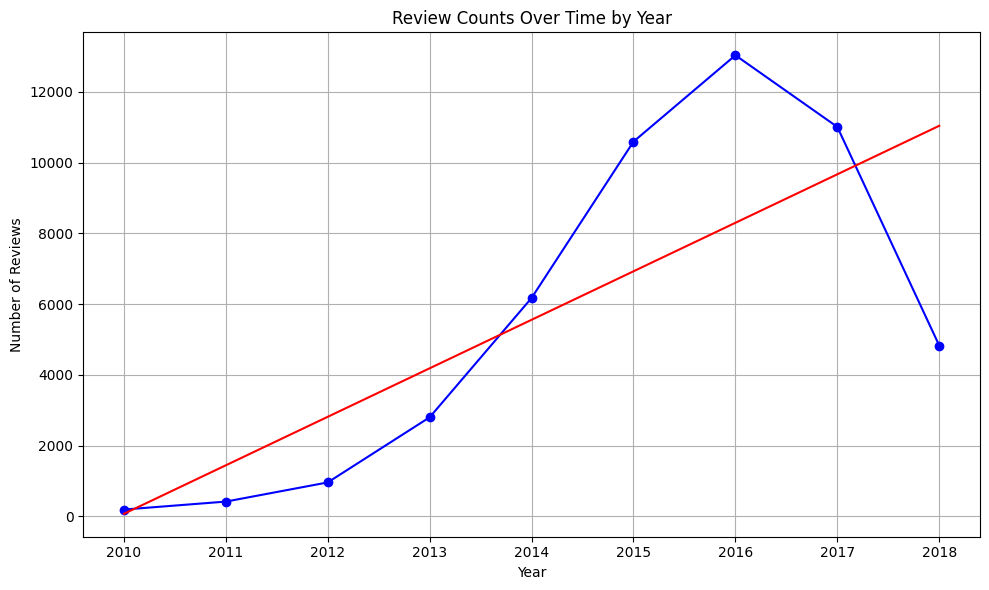

In [72]:
# Group by year and count reviews
review_counts_by_year = automotive_df_working_dedup_filter_sample.groupby('review_year').size()

# Plot the trend line
plt.figure(figsize=(10, 6))
review_counts_by_year.plot(marker='o', color='b', linestyle='-')
plt.title('Review Counts Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(review_counts_by_year.index)  # Set x ticks to be the years
plt.tight_layout()

# Add trend line
z = np.polyfit(review_counts_by_year.index, review_counts_by_year.values, 1)
p = np.poly1d(z)
plt.plot(review_counts_by_year.index, p(review_counts_by_year.index), color='r')

plt.show()

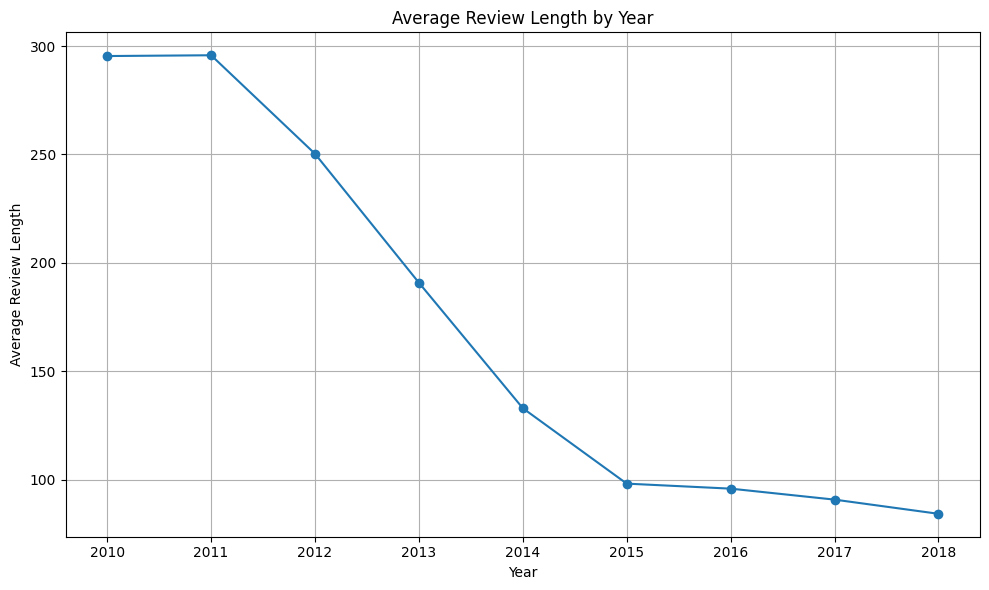

In [73]:
# Calculate review length for each review
automotive_df_working_dedup_filter_sample['review_length'] = automotive_df_working_dedup_filter_sample['review_text_clean'].apply(len)

# Group by year and calculate average review length
average_review_length_by_year = automotive_df_working_dedup_filter_sample.groupby('review_year')['review_length'].mean()

# Plot the average review length by year
plt.figure(figsize=(10, 6))
plt.plot(average_review_length_by_year.index, average_review_length_by_year.values, marker='o', linestyle='-')
plt.title('Average Review Length by Year')
plt.xlabel('Year')
plt.ylabel('Average Review Length')
plt.grid(True)
plt.xticks(average_review_length_by_year.index)  # Set x ticks to be the years
plt.tight_layout()
plt.show()


In [76]:
# Creating copy for backup
automotive_df_modeling = automotive_df_working_dedup_filter_sample.copy()

### Plotting top 20 n-grams

In [77]:
'''
This function compares the distribution of top n-grams (unigrams or bigrams) for two groups in a DataFrame.

Args:
  df: The DataFrame containing the text data and a column for the comparison group ('helpfulness_binary').
  helpfulness_values: A list of the two values to compare (e.g., [1, 0] for helpfulness).
  n: The n-gram value (1 for unigrams, 2 for bigrams).
  top_n: Number of top n-grams to visualize (default: 20)
'''

# The function output is the visualization of the top n-grams for a given dataframe
def compare_top_ngram_distribution(df, helpfulness_values, n, top_n=20):
  # Creating TF-IDF vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(n, n), lowercase=True, sublinear_tf=True)

  # Handling lists of tokens in 'review_text_clean'
    def preprocess_text(text):
        if isinstance(text, list):
            return ' '.join(text)
        else:
            return text
    #Added to drop nan
    # df.dropna(subset=['review_text_clean'], inplace=True)
    # data = df['review_text_clean'].apply(preprocess_text)
    # vectorizer.fit_transform(data)

    # Preprocessing text and fit vectorizer
    data = df['review_text_clean'].apply(preprocess_text)
    vectorizer.fit_transform(data)

    # Getting TF-IDF scores for each helpfulness value
    tfidf_matrix = vectorizer.transform(data)
    tfidf_by_helpfulness = {val: tfidf_matrix[df['helpfulness_binary'] == val].toarray() for val in helpfulness_values}

    # Getting vocabulary
    vocabulary = vectorizer.get_feature_names_out()

    # Calculating average TF-IDF scores for top n-grams per helpfulness value
    top_ngram_scores = {}
    for val in helpfulness_values:
        tfidf_data = tfidf_by_helpfulness[val]
        top_ngram_indices = tfidf_data.sum(axis=0).argsort()[-top_n:]  # Get indices of top n words by sum of TF-IDF
        top_ngram_scores[val] = [ (vocabulary[i], tfidf_data[:, i].mean()) for i in top_ngram_indices ]

    # Plotting
    plt.figure(figsize=(10, 6))
    
  # Preparing data for visualization (separate lists for ngrams and TF-IDF by helpfulness)
    ngrams = []
    avg_tfidf_by_helpfulness = {}
    for val, scores in top_ngram_scores.items():
        ngrams.extend([ngram for ngram, _ in scores])  # ngram for labels
        avg_tfidf_by_helpfulness[f"Helpfulness={val}"] = [tfidf for _, tfidf in scores]

  # Sorting together by TF-IDF (descending)
    sorted_data = sorted(zip(ngrams, *avg_tfidf_by_helpfulness.values()), key=lambda x: x[1], reverse=True)
    sorted_ngrams, *sorted_tfidf_by_helpfulness = zip(*sorted_data)

  # Creating colors for each helpfulness value (adjust as needed)
    colors = ['blue', 'orange']

  # Creating clustered column chart
    x = range(len(sorted_ngrams))  # x-axis positions
    bar_width = 0.35  # Adjust bar width for better visualization
    plt.bar(x[:top_n], sorted_tfidf_by_helpfulness[0][:top_n], bar_width, label=f"Helpfulness={helpfulness_values[0]}", color=colors[0])
    plt.bar([p + bar_width for p in x[:top_n]], sorted_tfidf_by_helpfulness[1][:top_n], 
            bar_width, label=f"Helpfulness={helpfulness_values[1]}", color=colors[1])

  # Setting x-axis labels with rotation for readability
    plt.xticks([p + bar_width/2 for p in x[:top_n]], sorted_ngrams[:top_n], rotation=60)
    plt.xlabel("Top N-Grams")
    plt.ylabel("Average TF-IDF Score")
    plt.title(f"Distribution of Top {n}-Gram TF-IDF Scores by Helpfulness Rating")
    plt.legend()
    plt.tight_layout()
    plt.show()


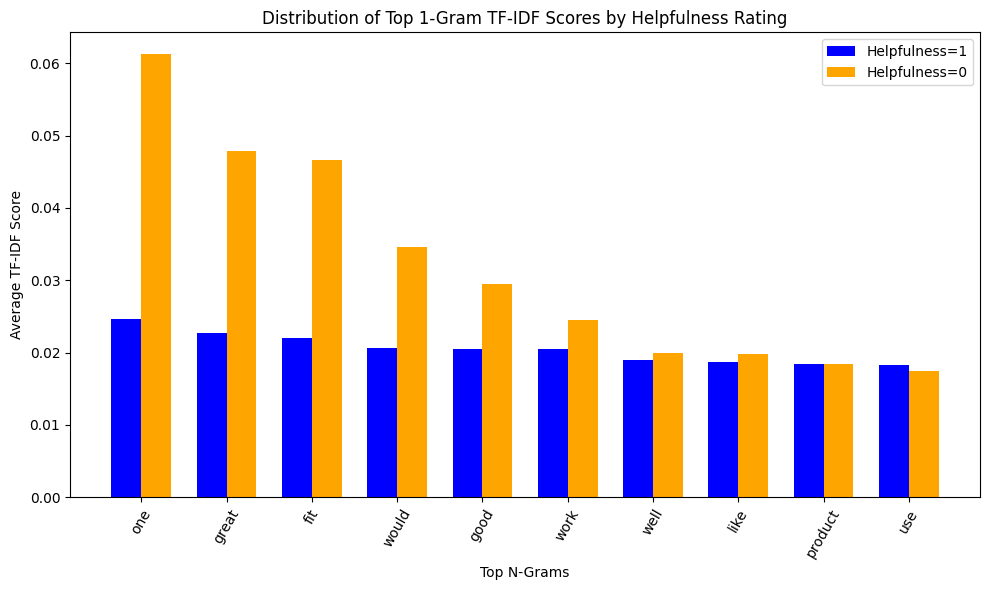

In [78]:
helpfulness_values = [1, 0]  # List of helpfulness ratings to compare

# Compare top 10 unigram distribution 
compare_top_ngram_distribution(automotive_df_modeling.copy(), helpfulness_values, 1, top_n=10)

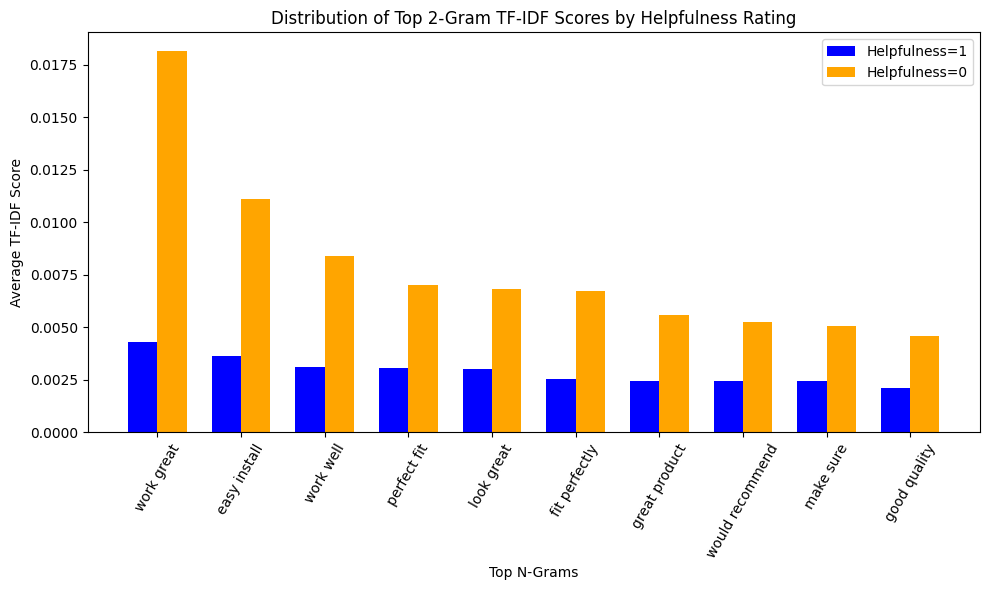

In [79]:
# Compare top 20 bigram distribution
compare_top_ngram_distribution(automotive_df_modeling.copy(), helpfulness_values, 2, top_n=10)

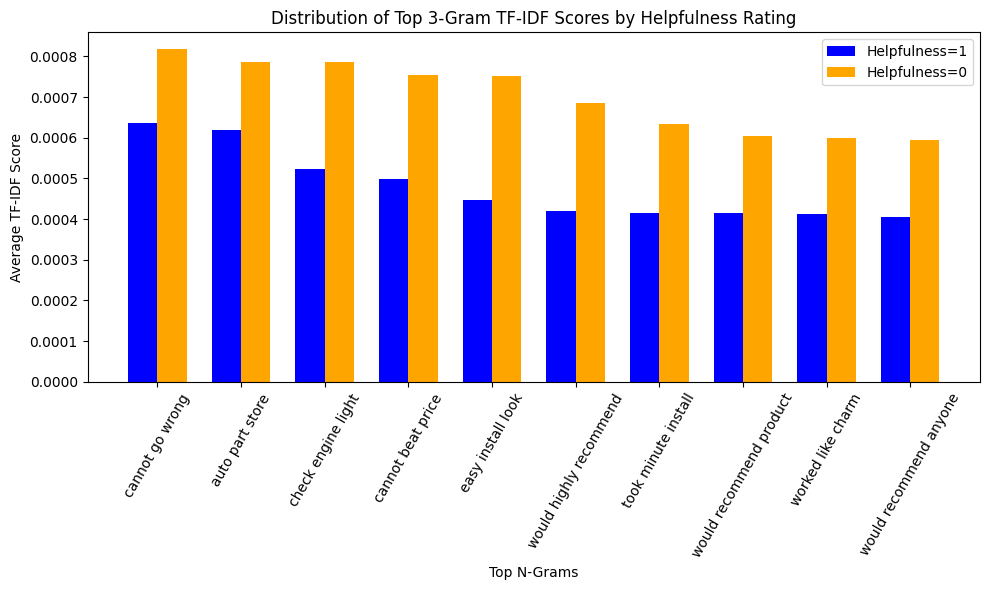

In [80]:
# Compare top 20 trigram distribution
compare_top_ngram_distribution(automotive_df_modeling.copy(), helpfulness_values, 3, top_n=10)

## Additional plots and stats 

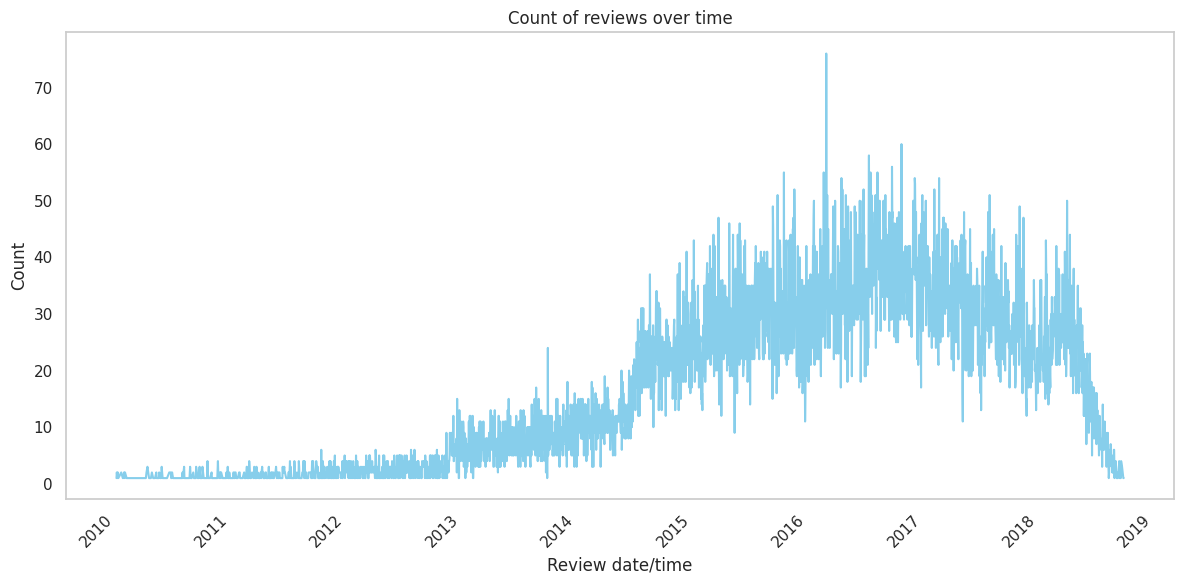

In [151]:
# Trend chart - count of reviews over time
# This can be done on the dataset before sampling as well, change the df name accordingly

import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn plots
sns.set_style("whitegrid")

# Converting reviewTime_cleaned to datetime if it's not already in datetime format
automotive_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(automotive_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Aggregating the data by date to reduce the number of data points in the chart
review_count_over_time = automotive_df_working_dedup_filter_sample.groupby('reviewTime_cleaned').size().reset_index(name='count')

# Plotting count of reviews over time (trend) using a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='reviewTime_cleaned', y='count', data=review_count_over_time, color='skyblue')
plt.title('Count of reviews over time')
plt.xlabel('Review date/time')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

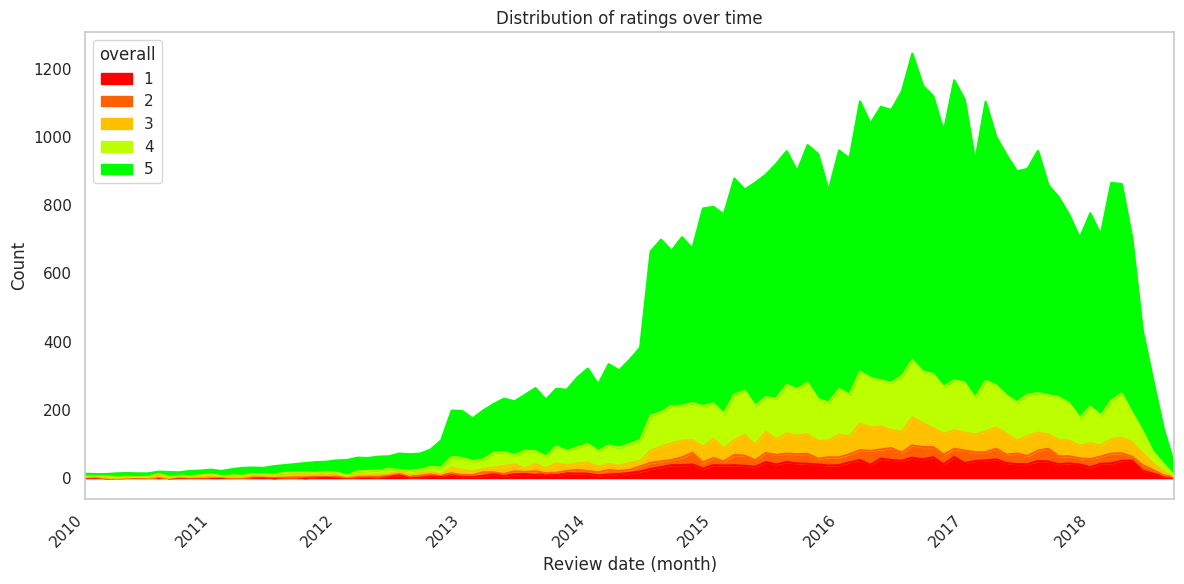

In [158]:
# Trend chart - distribution of star rating (overall column) over time
# This can be done on the dataset before sampling as well, change the df name accordingly

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Defining the custom colormap for ratings from red to green
colors = [(1, 0, 0), (1, 0.5, 0), (1, 1, 0), (0, 1, 0)]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors)

# Aggregating the data by month and rating
ratings_over_time_agg = automotive_df_working_dedup_filter_sample.groupby([automotive_df_working_dedup_filter_sample['reviewTime_cleaned'].dt.to_period('M'), 'overall']).size().unstack().fillna(0)

# Plotting stacked bar chart for the distribution of ratings over time
plt.figure(figsize=(12, 6))
ratings_over_time_agg.plot(kind='area', stacked=True, cmap=cmap, figsize=(12, 6))
plt.title('Distribution of ratings over time')
plt.xlabel('Review date (month)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6898: RuntimeWarning:

invalid value encountered in multiply



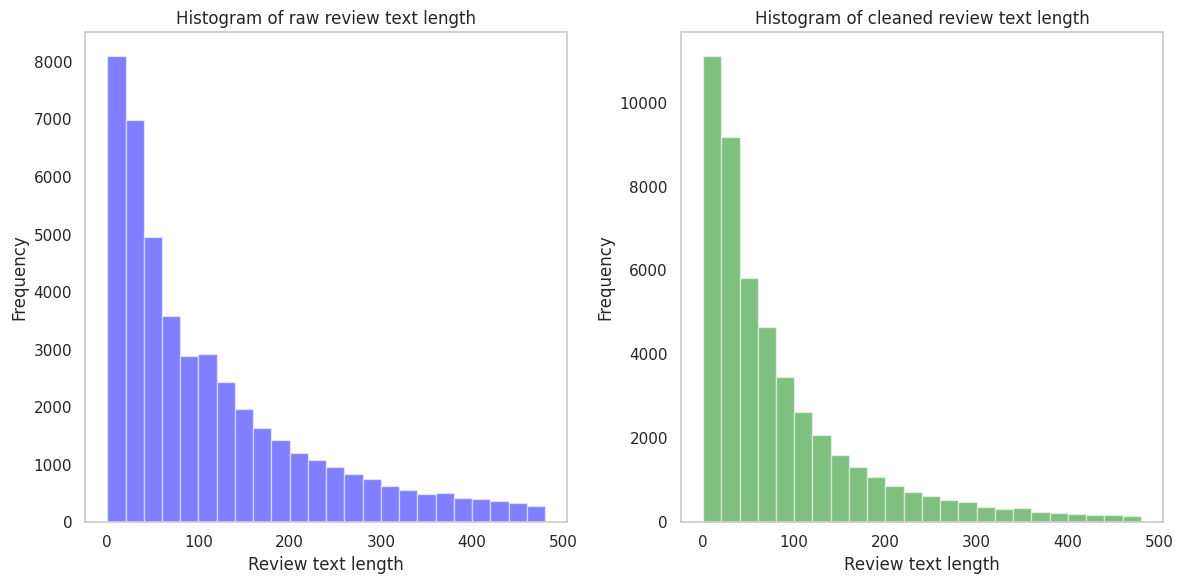

In [159]:
# Pre and post histogram for comparing length of review text before and after cleaning is done
# We can notice the concentration of the lower review text length increases after cleaning 
# i.e. relatively lower review text length become even lower 
# This indicates that there are a lot of characters getting removed due to our cleaning steps 
# This is because of the removal of stopwords, URLs, emojis, etc.
# X and Y axes of both charts are kept in sync to make the change visible

import numpy as np
import matplotlib.pyplot as plt

# Calculating the length of the text in the raw and cleaned review text columns
reviewtext_raw_lengths = automotive_df_working_dedup_filter_sample['reviewText'].apply(len)
reviewtext_cleaned_lengths = automotive_df_working_dedup_filter_sample['review_text_clean'].apply(len)

# Defining custom bins
# Bins from 0 to 500 with step size 20
custom_bins_reviewtext_len = np.arange(0, 500, 20)
# Appending infinity to include values above 500
custom_bins_reviewtext_len = np.append(custom_bins_reviewtext_len, np.inf)

# Defining subplots with same x & y axes ranges (to make the charts comparable) 
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plotting histogram for raw review text lengths
axes[0].hist(reviewtext_raw_lengths, bins=custom_bins_reviewtext_len, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw review text length')
axes[0].set_xlabel('Review text length')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned review text lengths
axes[1].hist(reviewtext_cleaned_lengths, bins=custom_bins_reviewtext_len, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned review text length')
axes[1].set_xlabel('Review text length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

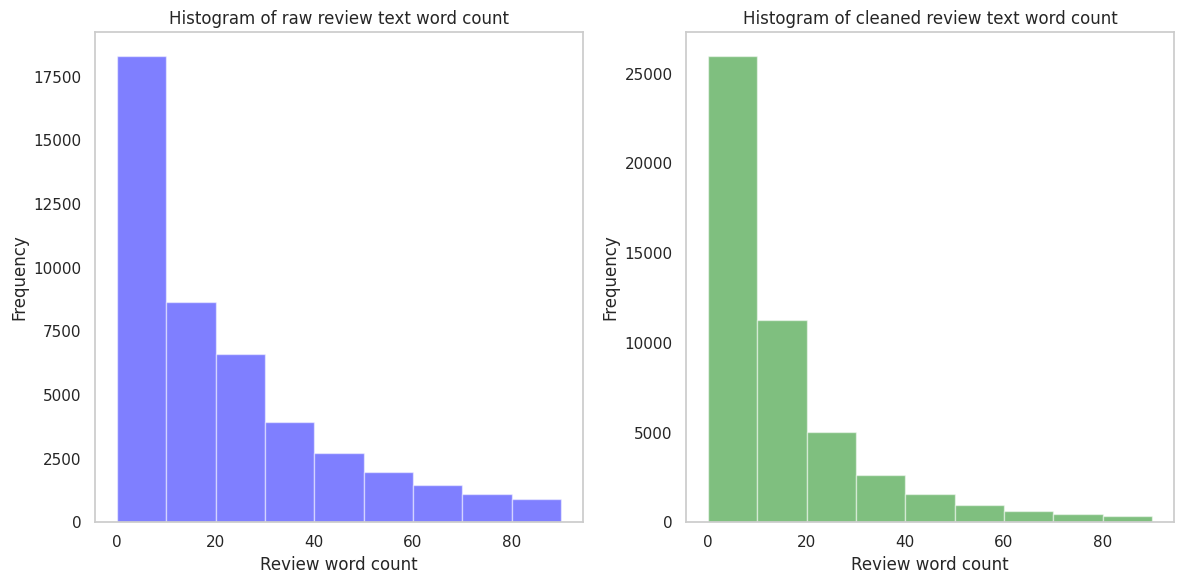

In [160]:
# Pre and post histogram for comparing word count of review text before and after cleaning is done
# We can notice the concentration of the lower review word count increases after cleaning 
# This indicates that there are a lot of words  getting removed due to our cleaning steps 
# This is because of the removal of stopwords, URLs, emojis, etc.
# X and Y axes of both charts are kept in sync to make the change visible

# Calculating the word count of the text in the raw and cleaned review columns
reviewtext_raw_wordlengths = automotive_df_working_dedup_filter_sample['reviewText'].str.split().apply(len)
reviewtext_cleaned_wordlengths = automotive_df_working_dedup_filter_sample['review_text_clean'].str.split().apply(len)

# Defining custom bins
# Bins from 0 to 100 with step size 10
custom_bins_review_words = np.arange(0, 100, 10)  
# Appending infinity to include values above 100
custom_bins_review_words = np.append(custom_bins_review_words, np.inf)  

# Defining subplots with same x & y axes ranges (to make the charts comparable) 
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plotting histogram for raw word counts in review text
axes[0].hist(reviewtext_raw_wordlengths, bins=custom_bins_review_words, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw review text word count')
axes[0].set_xlabel('Review word count')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned word counts in review text
axes[1].hist(reviewtext_cleaned_wordlengths, bins=custom_bins_review_words, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned review text word count')
axes[1].set_xlabel('Review word count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [155]:
# Function to do a t-test for a given metadata feature 
# When we compare the values of a feature between helpful and non helpful reviews, we want to know if the difference is statistically significant
# This can be done using a t-test
# If the p-value <0.05, we can say that the null hypothesis of no difference betweent the means can be rejected
# What this means is that there is a statistically significant difference between the feature's value between helpful and non-helpful reviews

from scipy.stats import ttest_ind

def t_test_metadata(df, metadata_column, helpfulness_column):
    # Separating data into helpful and non-helpful reviews for comparison
    helpful_reviews = df[df[helpfulness_column] == 1][metadata_column]
    non_helpful_reviews = df[df[helpfulness_column] == 0][metadata_column]
    
    # Performing t-test
    t_statistic, p_value = ttest_ind(helpful_reviews, non_helpful_reviews)
    
    return p_value

In [157]:
# Using the t-test function
metadata_column = 'title_length'  
helpfulness_column = 'helpfulness_binary'  

p_value = t_test_metadata(automotive_df_working_dedup_filter_sample, metadata_column, helpfulness_column)
if p_value < 0.05:
    print(f"There is a statistically significant difference between helpful and non-helpful reviews for the {metadata_column} feature since the p-value of the difference is {p_value:.4f}")
else:
    print(f"There is no statistically significant difference between helpful and non-helpful reviews for the {metadata_column} feature since the p-value of the difference is {p_value:.4f}")

There is a statistically significant difference between helpful and non-helpful reviews for the title_length feature since the p-value of the difference is 0.0000


### Modeling

#### Steps:
1) Choosing ONLY metadata features for correlation (there will be 5k tfidf features, not feasible to check correlation)
2) Define high correlation threshold, can be >=0.85 for high positive correlation and <=-0.85 for high negative correlation
3) Checking correlation matrix and excluding highly correlated unimportant features
4) Visualizing correlation matrix again with final list and ensure that no two features are outside correlation thresholds
5) Creating TFIDF matrix and convert to dataframe
6) Modeling dataframes - X will contain all features i.e. TFIDF features and finalized metadata features, y will contain the target variable i.e. helpfulness_binary
7) Split of modeling datasets into train (70%), test (15%), and validation (15%)
8) Training the supervised ML models; 2 sets of models will be trained - base models and tuned models
9) Base models will run with default parameters while tuned models will be run after identifying optimal parameters obtained from hyperparameter tuning
10) Compare the base and tuned models' performance
11) Compare the models
12) Feature importance of the models
13) Model explainability (extension of feature importance) and identifying drivers of helpfulness for insights
    - For tree-based models (Random Forest / XGBoost) - feature importance of review terms

### Model dataset creation

In [81]:
# Specifying the metadata features for checking correlation
other_meta_features = [
                  'image_available',
                  'title_length',
                  'num_words_review_title', #'title_review_similarity', # commented if not calculated
                  'title_sentiment',
                  'unique_word_count_title',
                  'emoji_non_ascii_count_title',
                  'review_length',
                  'review_sentiment',
                  'num_words_review_text',
                  'url_count_review',
                  'unique_word_count_review',
                  'stop_word_count_review',
                  'review_age_days'
                 ]

# Getting only metadata feature columns for correlation checks
metadata_features_corr_check = automotive_df_modeling[other_meta_features]

In [82]:
# Metadata features for correlation check
metadata_features_corr_check.columns

Index(['image_available', 'title_length', 'num_words_review_title',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'review_length', 'review_sentiment',
       'num_words_review_text', 'url_count_review', 'unique_word_count_review',
       'stop_word_count_review', 'review_age_days'],
      dtype='object')

In [83]:
metadata_features_corr_check.shape

(50002, 13)

### Initial correlation matrix

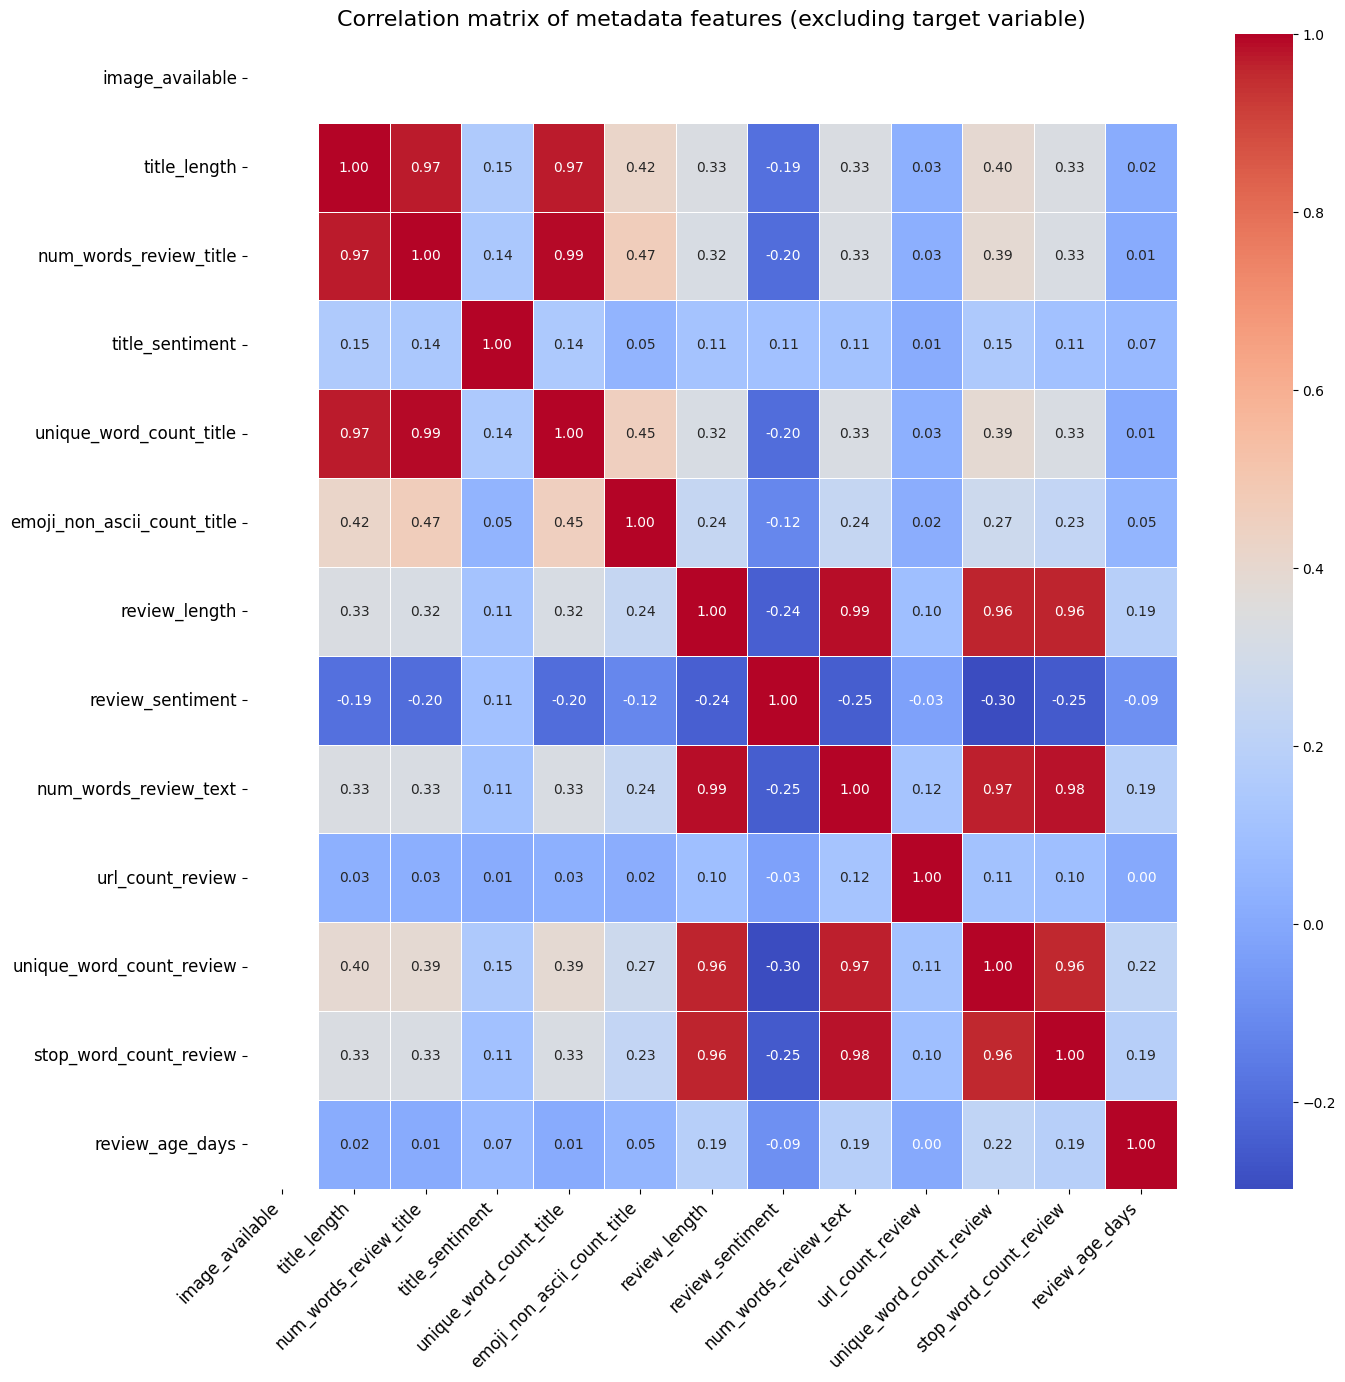

In [84]:
# Getting only metadata feature columns to check correlation
correlation_matrix_corr_check = metadata_features_corr_check.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_corr_check, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increase title fontsize
plt.show()

In [85]:
# After studying the above matrix and I have removed correlated metadata features
correlation_matrix_corr_check

,image_available,title_length,num_words_review_title,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title,review_length,review_sentiment,num_words_review_text,url_count_review,unique_word_count_review,stop_word_count_review,review_age_days
image_available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title_length,NaN,1.000000,0.970010,0.154410,0.971094,0.421634,0.333566,-0.189818,0.331815,0.026791,0.395513,0.331383,0.015908
num_words_review_title,NaN,0.970010,1.000000,0.142975,0.992990,0.465872,0.321601,-0.197103,0.326647,0.025983,0.389808,0.328201,0.010610
title_sentiment,NaN,0.154410,0.142975,1.000000,0.143683,0.045861,0.114239,0.107782,0.111958,0.011685,0.152366,0.107644,0.070072
unique_word_count_title,NaN,0.971094,0.992990,0.143683,1.000000,0.454617,0.322287,-0.199358,0.326602,0.026837,0.391014,0.328338,0.010510
emoji_non_ascii_count_title,NaN,0.421634,0.465872,0.045861,0.454617,1.000000,0.240734,-0.116841,0.242666,0.019490,0.272269,0.232329,0.048708
review_length,NaN,0.333566,0.321601,0.114239,0.322287,0.240734,1.000000,-0.237595,0.989480,0.096224,0.961595,0.964117,0.185068
review_sentiment,NaN,-0.189818,-0.197103,0.107782,-0.199358,-0.116841,-0.237595,1.000000,-0.246486,-0.025560,-0.297645,-0.254790,-0.086725
num_words_review_text,NaN,0.331815,0.326647,0.111958,0.326602,0.242666,0.989480,-0.246486,1.000000,0.119040,0.966955,0.980641,0.187490
url_count_review,NaN,0.026791,0.025983,0.011685,0.026837,0.019490,0.096224,-0.025560,0.119040,1.000000,0.110280,0.095371,0.001824


### After analysing correlation matrix, there are a lot of correlated feature. After careful examing the matrix deciding the threshold as more than 0.85. Any feature that is more than 0.85 is highly postively correlated. Any feature that is less than -0.85 is highly negatively correlated.

In [86]:
# Removing highly negatively and postively correlated features
# Uncorrelated metadata features are identified through manual judgement i.e. heuristic approach

# Droping the columns from the dataframe
corr_columns_to_drop = ["review_length", "stop_word_count_review",
                        "unique_word_count_title","num_words_review_title","num_words_review_text",
                        # Removing image_available since it's binary/boolen and isn't relevant for correlation checks
                        "image_available"]
metadata_features_corr_check.drop(columns=corr_columns_to_drop, inplace=True)

In [87]:
metadata_features_corr_check.shape

(50002, 7)

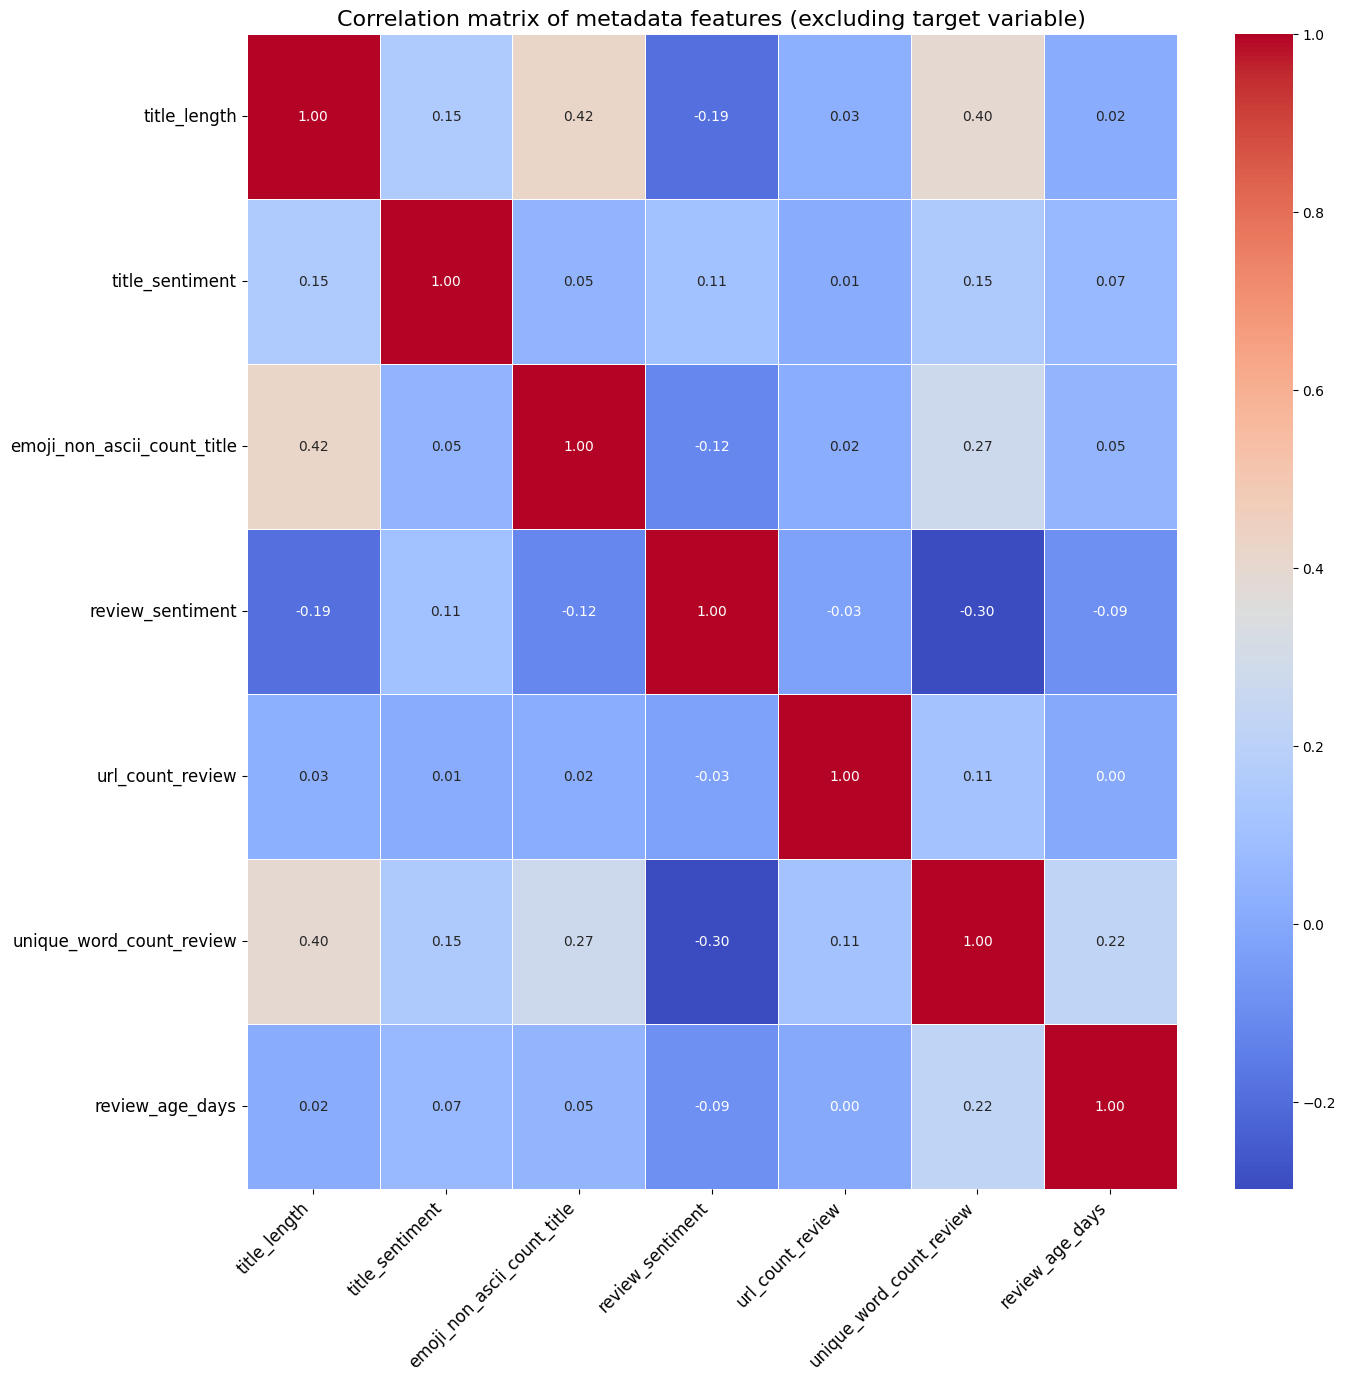

In [88]:
# Getting only uncorrelated metadata feature columns to check correlation
metadata_features_final = metadata_features_corr_check.copy()
correlation_matrix_final = metadata_features_final.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_final, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keeping y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increasing title fontsize
plt.show()

#### After removing highly corelated features above matrix is the final correlation matrix.

In [89]:
# Creating final modeling dataset

# Defining the columns to be taken in modeling dataset
target_column = 'helpfulness_binary'  # Helpfulness is binary (1 or 0)
# Defining final metadata features after ensuring that no independent metadata features are highly correlated
# List of columns comes from metadata_features_final.columns
final_meta_features = ['title_length', 'title_sentiment', 'emoji_non_ascii_count_title', 'review_sentiment',
                       'url_count_review', 'unique_word_count_review','review_age_days',
                       # including image_available since it was dropped in correlation matrix
                       'image_available']

# Getting only metadata feature columns
modeling_df_meta_final = automotive_df_modeling[final_meta_features]

In [90]:
automotive_df_modeling.shape

(50002, 35)

In [91]:
modeling_df_meta_final.shape

(50002, 8)

### Modelling and generating features

In [92]:
# Creating TFIDF matrix of cleaned review text and storing in a df
# Custom tokenizer function
def custom_tokenizer(text):
    # Splitting text into words using a simple whitespace tokenizer
    words = text.split()
    return words

# Tokenizing text using custom tokenizer
tokenized_text = automotive_df_modeling['review_text_clean'].apply(custom_tokenizer).apply(' '.join)

# Creating TF-IDF vectorizer instance with custom tokenizer and top 1000 features
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_text)

# Converting TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [93]:
tfidf_df.shape

(50002, 1000)

In [94]:
# Combining TF-IDF features with other features

# Restting index on both TFIDF dataframe and metadata feature dataframe
tfidf_df.reset_index(drop=True, inplace=True)
modeling_df_meta_final.reset_index(drop=True, inplace=True)

# Splitting into X and y for modeling
# Concatinating the tfidf_df and Modeling
# X will have the TFIDF df and the final metadata features
X = pd.concat([tfidf_df, modeling_df_meta_final], axis=1)

# y will have the target variable
y = automotive_df_modeling[target_column]

In [164]:

X.to_csv('Automotive_Modeling.csv', index=False)

In [95]:
# Checking size - this should be the same as the stratified sample output df size
X.shape

(50002, 1008)

In [165]:
X.to_csv('Automotive_Modeling.csv', index=False)

In [167]:
automotive_df_modeling.to_csv('Automotive_Modeling_2.csv', index=False)

In [168]:
test_df =pd.read_csv('Automotive_Modeling.csv')
test_df.shape

(50002, 1008)

In [169]:
test_df =pd.read_csv('Automotive_Modeling_2.csv')
test_df.shape

(50002, 35)

### Splitting as testing (70%), training (15%) and validation (15%)

In [96]:
# Step 1: Splitting the data into training (70%) and temporary data (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)

# Step 2: Splitting the temporary data into testing (50%) and validation (50%)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Displaying the shapes of the resulting datasets
## Training ##
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
## Testing ##
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
## Validation ##
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)

X_train shape: (35001, 1008)
y_train shape: (35001,)
X_test shape: (7500, 1008)
y_test shape: (7500,)
X_validation shape: (7501, 1008)
y_validation shape: (7501,)


## Modeling - Supervised ML models to predict helpfulness

In [119]:
# Libraries required for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, f1_score, auc
import matplotlib.pyplot as plt
import pandas as pd
import shap
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay,confusion_matrix

### Pickling model files to easily save and load

In [98]:
# Function to save model as pickle file

def save_model_pickle(trained_model, pickle_filename):
    """
    Save a trained model to a pickle file.

    Parameters:
        model: Trained machine learning model object.
        filename (str): Name of the pickle file to save the model to.
    """
    with open(pickle_filename, 'wb') as file:
        pickle.dump(trained_model, file)
    print(f"Model saved as {pickle_filename}")

# Example of usage: save_model_pickle(rf_classifier, 'rf_classifier_appliances.pkl')
    
# Function to load model from pickle file
def load_model_pickle(pickle_filename):
    """
    Load a trained model from a pickle file.

    Parameters:
        filename (str): Name of the pickle file containing the saved model.

    Returns:
        Trained machine learning model object.
    """
    with open(pickle_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Model loaded from {pickle_filename}")
    return loaded_model

# Example of usage: rf_classifier_appliances = load_model_pickle('rf_classifier_appliances.pkl')


### Modeling - Random Forest

### Base Model

In [99]:
# Random Forest Classifier - base model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest base model accuracy:", rf_accuracy)
print("Random Forest base model classification report:")
print(classification_report(y_test, rf_predictions))

Random Forest base model accuracy: 0.8954666666666666
Random Forest base model classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      6717
           1       0.47      0.01      0.02       783

    accuracy                           0.90      7500
   macro avg       0.68      0.50      0.48      7500
weighted avg       0.85      0.90      0.85      7500



In [100]:
# Saving as pickle file
save_model_pickle(rf_classifier, 'rf_base_classifier_automotive.pkl')

Model saved as rf_base_classifier_automotive.pkl


### Hyperparameter Tuning

In [101]:
# Random Forest Classifier - Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=123), param_grid=rf_param_grid, cv=3, scoring='accuracy')
# Hyperparameter tuning on validation dataset
rf_grid_search.fit(X_validation, y_validation)
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_
print("Random Forest Best Parameters:", rf_best_params)

rf_tuned_predictions = rf_grid_search.predict(X_test)

rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_predictions)
print("Random Forest tuned model accuracy:", rf_tuned_accuracy)
print("Random Forest tuned model classification report:")
print(classification_report(y_test, rf_tuned_predictions))

Random Forest Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Random Forest tuned model accuracy: 0.8957333333333334
Random Forest tuned model classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      6717
           1       0.60      0.00      0.01       783

    accuracy                           0.90      7500
   macro avg       0.75      0.50      0.48      7500
weighted avg       0.87      0.90      0.85      7500



In [102]:
# Saving as pickle file
save_model_pickle(rf_best_model, 'rf_tuned_classifier_automotive.pkl')

Model saved as rf_tuned_classifier_automotive.pkl


### Modeling - Logistic Regression

### Base Model

In [103]:
# Logistic Regression - base model
lr_classifier = LogisticRegression(max_iter=1000, random_state=123)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression base model accuracy:", lr_accuracy)
print("Logistic Regression base model classification report:")
print(classification_report(y_test, lr_predictions))

Logistic Regression base model accuracy: 0.8985333333333333
Logistic Regression base model classification report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      6717
           1       0.58      0.10      0.17       783

    accuracy                           0.90      7500
   macro avg       0.74      0.55      0.56      7500
weighted avg       0.87      0.90      0.86      7500



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [104]:
# Saving as pickle file
save_model_pickle(lr_classifier, 'lr_base_classifier_automotive.pkl')

Model saved as lr_base_classifier_automotive.pkl


### Hyperparameter Tuning

In [105]:
# Logistic Regression - Hyperparameter Tuning
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 20],
    'penalty': ['l1', 'l2']
}

lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=123),
                              param_grid=lr_param_grid, cv=3, scoring='accuracy')

# Hyperparameter tuning on validation dataset
lr_grid_search.fit(X_validation, y_validation)
lr_best_params = lr_grid_search.best_params_
lr_best_model = lr_grid_search.best_estimator_
print("Logistic Regression Best Parameters:", lr_best_params)

lr_tuned_predictions = lr_grid_search.predict(X_test)

lr_tuned_predictions = lr_grid_search.predict(X_test)
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_predictions)
print("Logistic Regression tuned model accuracy:", lr_tuned_accuracy)
print("Logistic Regression tuned model classification report:")
print(classification_report(y_test, lr_tuned_predictions))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/

Logistic Regression Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Logistic Regression tuned model accuracy: 0.8961333333333333
Logistic Regression tuned model classification report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6717
           1       0.52      0.08      0.14       783

    accuracy                           0.90      7500
   macro avg       0.71      0.54      0.54      7500
weighted avg       0.86      0.90      0.86      7500



In [106]:
# Saving as pickle file
save_model_pickle(lr_best_model, 'lr_tuned_classifier_automotive.pkl')

Model saved as lr_tuned_classifier_automotive.pkl


### Modeling - SVM

### Base Model

In [107]:
# Support Vector Machine (SVM) - base model
svm_classifier = SVC(kernel='rbf', random_state=123)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM base model accuracy:", svm_accuracy)
print("SVM base model classification report:")
print(classification_report(y_test, svm_predictions))

SVM base model accuracy: 0.8956
SVM base model classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      6717
           1       0.00      0.00      0.00       783

    accuracy                           0.90      7500
   macro avg       0.45      0.50      0.47      7500
weighted avg       0.80      0.90      0.85      7500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [108]:
# Saving as pickle file
save_model_pickle(svm_classifier, 'svm_base_classifier_automotive.pkl')

Model saved as svm_base_classifier_automotive.pkl


### Hyperparameter Tuning

In [109]:
# Support Vector Machine (SVM) - Hyperparameter Tuning
svm_param_grid = {
    #'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_grid_search = GridSearchCV(SVC(random_state=123), param_grid=svm_param_grid, cv=3, scoring='accuracy')
#svm_grid_search.fit(X_train, y_train)
# Hyperparameter tuning on validation dataset
svm_grid_search.fit(X_validation, y_validation)
svm_best_params = svm_grid_search.best_params_
svm_best_model = svm_grid_search.best_estimator_

print("SVM Best Parameters:", svm_best_params)

svm_tuned_predictions = svm_grid_search.predict(X_test)

svm_tuned_predictions = svm_grid_search.predict(X_test)
svm_tuned_accuracy = accuracy_score(y_test, svm_tuned_predictions)
print("SVM tuned model accuracy:", svm_tuned_accuracy)
print("SVM tuned model classification report:")
print(classification_report(y_test, svm_tuned_predictions))

SVM Best Parameters: {'kernel': 'rbf'}
SVM tuned model accuracy: 0.8956
SVM tuned model classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      6717
           1       0.00      0.00      0.00       783

    accuracy                           0.90      7500
   macro avg       0.45      0.50      0.47      7500
weighted avg       0.80      0.90      0.85      7500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [110]:
# Saving as pickle file
save_model_pickle(svm_best_model, 'svm_tuned_classifier_automotive.pkl')

Model saved as svm_tuned_classifier_automotive.pkl


### Modeling - XGBoost

### Base Model

In [111]:
# XGBoost - base model
xgb_classifier = xgb.XGBClassifier(random_state=123)
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost base model accuracy:", xgb_accuracy)
print("XGBoost base model classification report:")
print(classification_report(y_test, xgb_predictions))

XGBoost base model accuracy: 0.8913333333333333
XGBoost base model classification report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6717
           1       0.40      0.08      0.14       783

    accuracy                           0.89      7500
   macro avg       0.65      0.53      0.54      7500
weighted avg       0.85      0.89      0.86      7500



In [112]:
# Saving as pickle file
save_model_pickle(xgb_classifier, 'xgb_base_classifier_automotive.pkl')

Model saved as xgb_base_classifier_automotive.pkl


### Hyperparameter Tuning

In [113]:
# XGBoost - Hyperparameter Tuning
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=123), param_grid=xgb_param_grid, cv=3, scoring='accuracy')

# Hyperparameter tuning on validation dataset
xgb_grid_search.fit(X_validation, y_validation)
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

print("XGBoost Best Parameters:", xgb_best_params)

xgb_tuned_predictions = xgb_best_model.predict(X_test)

xgb_tuned_predictions = xgb_grid_search.predict(X_test)
xgb_tuned_accuracy = accuracy_score(y_test, xgb_tuned_predictions)
print("XGBoost tuned model accuracy:", xgb_tuned_accuracy)
print("XGBoost tuned model classification report:")
print(classification_report(y_test, xgb_tuned_predictions))

XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGBoost tuned model accuracy: 0.8961333333333333
XGBoost tuned model classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6717
           1       0.75      0.01      0.02       783

    accuracy                           0.90      7500
   macro avg       0.82      0.50      0.48      7500
weighted avg       0.88      0.90      0.85      7500



In [114]:
# Saving as pickle file
save_model_pickle(xgb_best_model, 'xgb_tuned_classifier_automotive.pkl')

Model saved as xgb_tuned_classifier_automotive.pkl


### Model comparison and feature importance

### Preparing metric tables for tuned and base models

Random Forest Confusion Matrix:
[[6715    2]
 [ 780    3]]
Random Forest F1-Score: 0.007614213197969543
Random Forest AUC: 0.5017668328259571
Random Forest Accuracy: 0.8957333333333334
Random Forest Precision: 0.6
Random Forest Recall: 0.0038314176245210726

Logistic Regression Confusion Matrix:
[[6657   60]
 [ 719   64]]
Logistic Regression F1-Score: 0.14112458654906285
Logistic Regression AUC: 0.5364021750724558
Logistic Regression Accuracy: 0.8961333333333333
Logistic Regression Precision: 0.5161290322580645
Logistic Regression Recall: 0.08173690932311622

SVM Confusion Matrix:
[[6717    0]
 [ 783    0]]
SVM F1-Score: 0.0
SVM AUC: 0.5
SVM Accuracy: 0.8956
SVM Precision: 1.0
SVM Recall: 0.0

XGBoost Confusion Matrix:
[[6715    2]
 [ 777    6]]
XGBoost F1-Score: 0.015170670037926675
XGBoost AUC: 0.5036825416382177
XGBoost Accuracy: 0.8961333333333333
XGBoost Precision: 0.75
XGBoost Recall: 0.007662835249042145



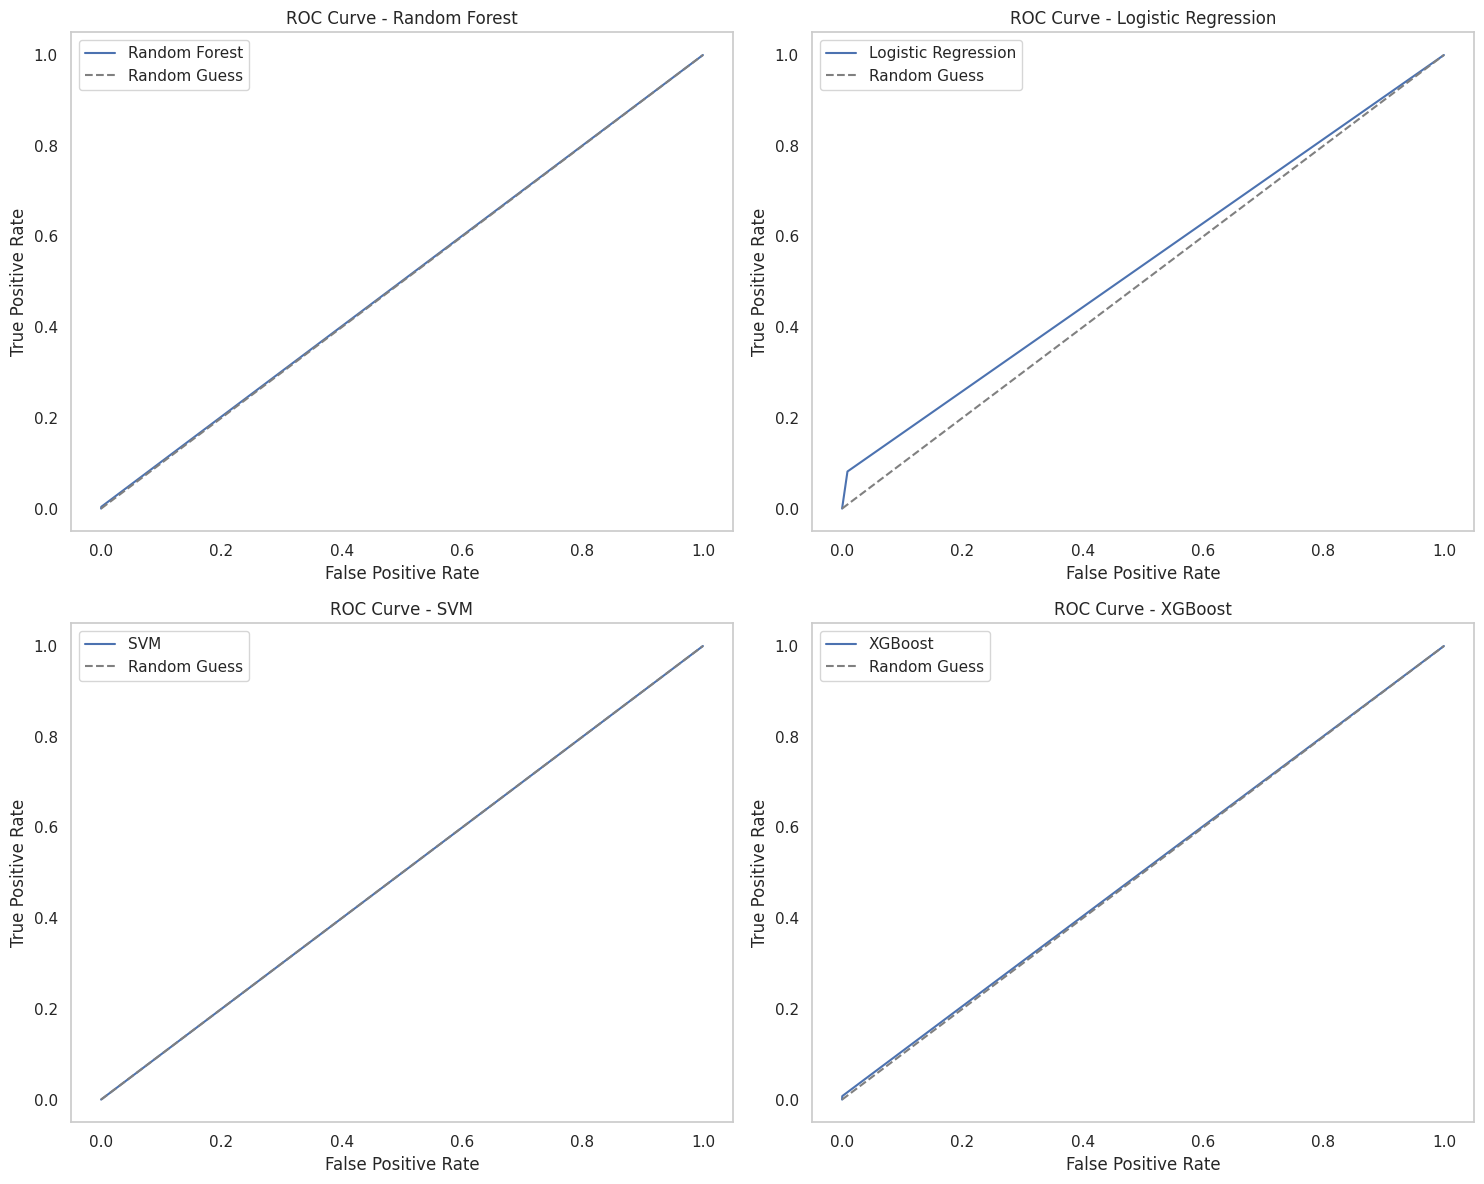

Random Forest Confusion Matrix:
[[6708    9]
 [ 775    8]]
Random Forest F1-Score: 0.02
Random Forest AUC: 0.5044386148943294
Random Forest Accuracy: 0.8954666666666666
Random Forest Precision: 0.47058823529411764
Random Forest Recall: 0.010217113665389528

Logistic Regression Confusion Matrix:
[[6662   55]
 [ 706   77]]
Logistic Regression F1-Score: 0.16830601092896175
Logistic Regression AUC: 0.5450757698913434
Logistic Regression Accuracy: 0.8985333333333333
Logistic Regression Precision: 0.5833333333333334
Logistic Regression Recall: 0.0983397190293742

SVM Confusion Matrix:
[[6717    0]
 [ 783    0]]
SVM F1-Score: 0.0
SVM AUC: 0.5
SVM Accuracy: 0.8956
SVM Precision: 1.0
SVM Recall: 0.0

XGBoost Confusion Matrix:
[[6619   98]
 [ 717   66]]
XGBoost F1-Score: 0.13938753959873285
XGBoost AUC: 0.5348506705408648
XGBoost Accuracy: 0.8913333333333333
XGBoost Precision: 0.4024390243902439
XGBoost Recall: 0.0842911877394636



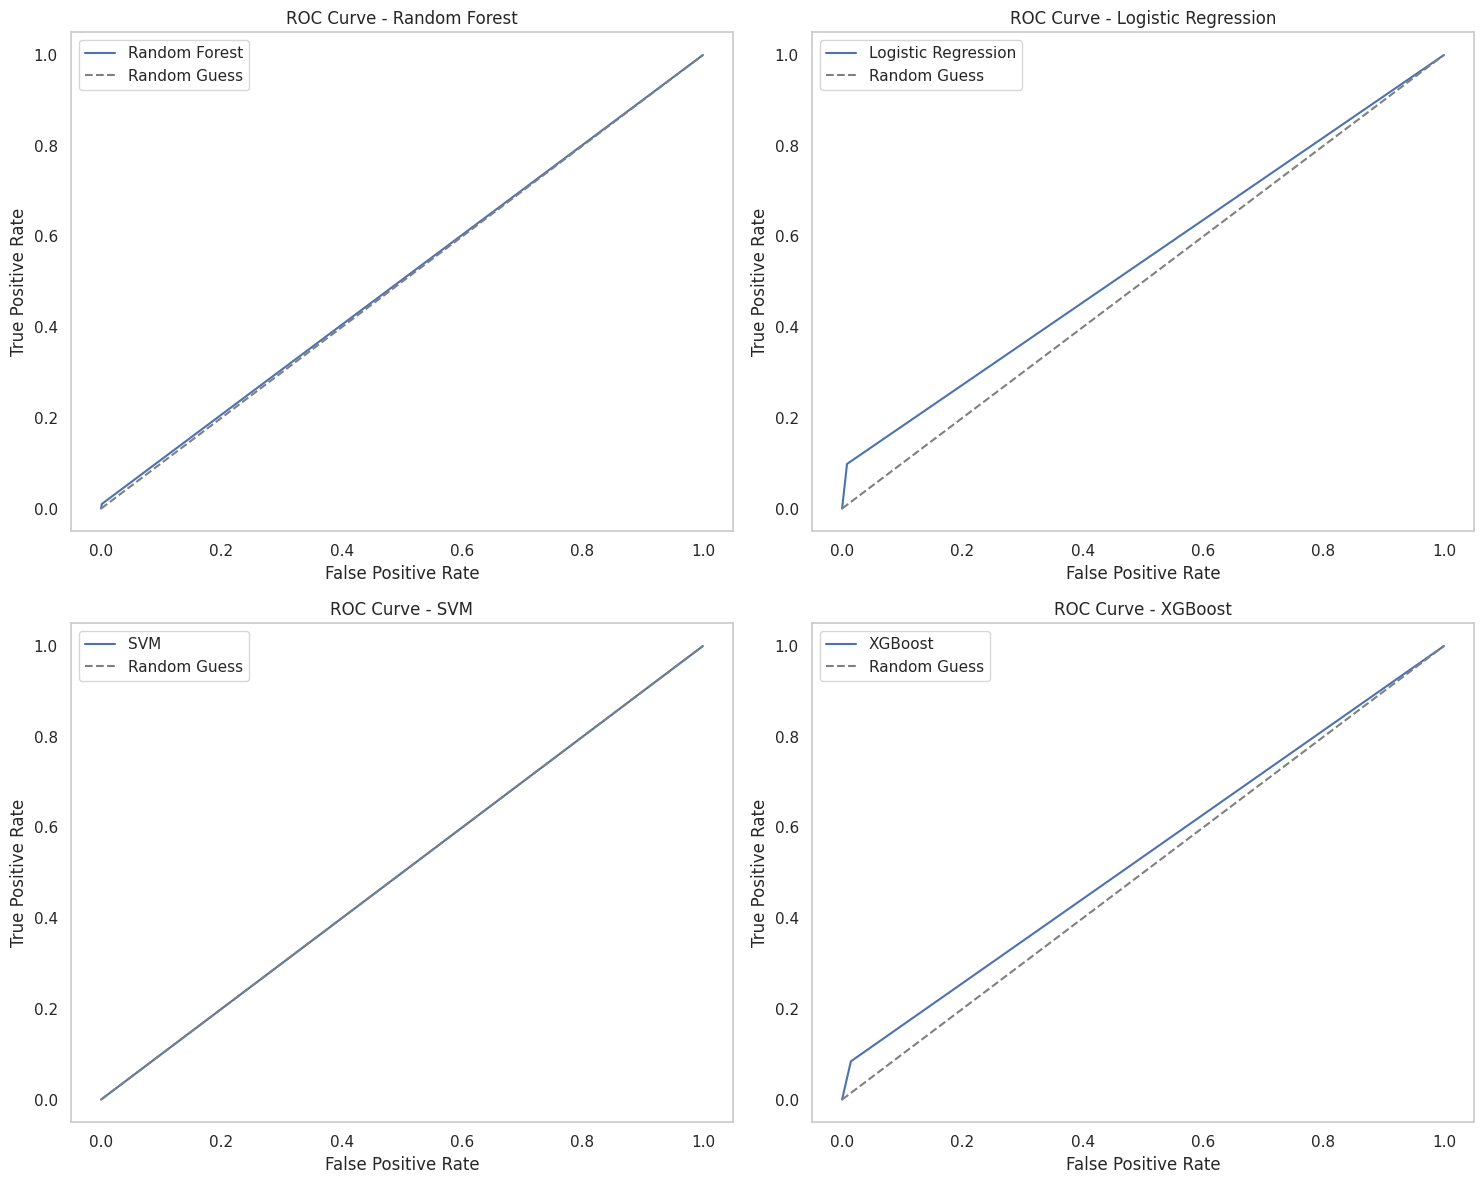

In [161]:
from sklearn.metrics import precision_score, recall_score
# Function to plot ROC curve
def plot_roc_curve(ax, fpr, tpr, model_name):
    ax.plot(fpr, tpr, label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend()
    ax.grid(True)

# Function to evaluate and compare models
def evaluate_models(models, X_test, y_test):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

    for model_name, model in models.items():
        ax = axes.flatten()[list(models.keys()).index(model_name)]

        # Predictions
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"{model_name} Confusion Matrix:")
        print(cm)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plot_roc_curve(ax, fpr, tpr, model_name)

        # F1-Score
        f1 = f1_score(y_test, y_pred)
        print(f"{model_name} F1-Score: {f1}")

        # Area under ROC curve
        roc_auc = auc(fpr, tpr)
        print(f"{model_name} AUC: {roc_auc}")

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {accuracy}")

        # Precision
        precision = precision_score(y_test, y_pred, zero_division=1)
        print(f"{model_name} Precision: {precision}")

        # Recall
        recall = recall_score(y_test, y_pred)
        print(f"{model_name} Recall: {recall}")

        print()

    plt.tight_layout()
    plt.show()

# Defining the models to compare
tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}


base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}


# Evaluation and comparison of models
evaluate_models(tuned_models, X_test, y_test)
evaluate_models(base_models, X_test, y_test)

It looks like all four models have almost identical ROC curves which closely mimic the random guess line showing that these models are not performing better than chance in this specific task. Since data is specific to a category the data is imbalanced

### Consolidating all evaluation metrics results in one dataframe

In [118]:
# Function to generate evaluation results
def generate_evaluation_results(models, X_test, y_test):
    results = []
    
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        })
    
    return pd.DataFrame(results)

# Defining the base models to compare
base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}

# Defining the tuned models to compare
tuned_models = {
    "Random Forest (Tuned)": rf_best_model,
    "Logistic Regression (Tuned)": lr_best_model,
    "SVM (Tuned)": svm_best_model,
    "XGBoost (Tuned)": xgb_best_model
}

# Generating evaluation results for base models
base_evaluation_results = generate_evaluation_results(base_models, X_test, y_test)

# Generating evaluation results for tuned models
tuned_evaluation_results = generate_evaluation_results(tuned_models, X_test, y_test)

# Combining the results of base and tuned models
consolidated_evaluation_results = pd.concat([base_evaluation_results, tuned_evaluation_results], ignore_index=True)

consolidated_evaluation_results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.895467,0.470588,0.010217,0.020000,0.504439
1,Logistic Regression,0.898533,0.583333,0.098340,0.168306,0.545076
2,SVM,0.895600,0.000000,0.000000,0.000000,0.500000
3,XGBoost,0.891333,0.402439,0.084291,0.139388,0.534851
4,Random Forest (Tuned),0.895733,0.600000,0.003831,0.007614,0.501767
5,Logistic Regression (Tuned),0.896133,0.516129,0.081737,0.141125,0.536402
6,SVM (Tuned),0.895600,0.000000,0.000000,0.000000,0.500000
7,XGBoost (Tuned),0.896133,0.750000,0.007663,0.015171,0.503683


There no much improvement on the matrix after hyperparameter tuning

### Plotting Confusion Matrix for base

Logistic Regression Confusion Matrix:
[[6662   55]
 [ 706   77]]


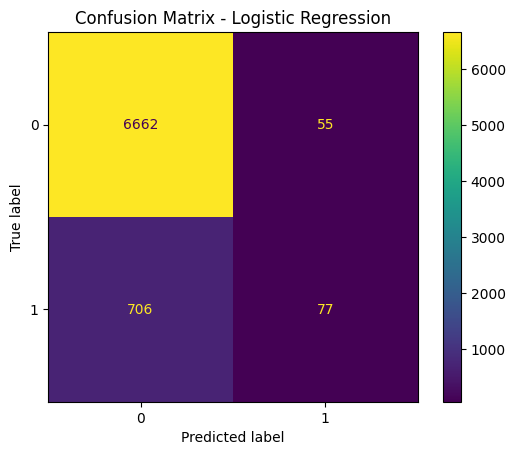

SVM Confusion Matrix:
[[6717    0]
 [ 783    0]]


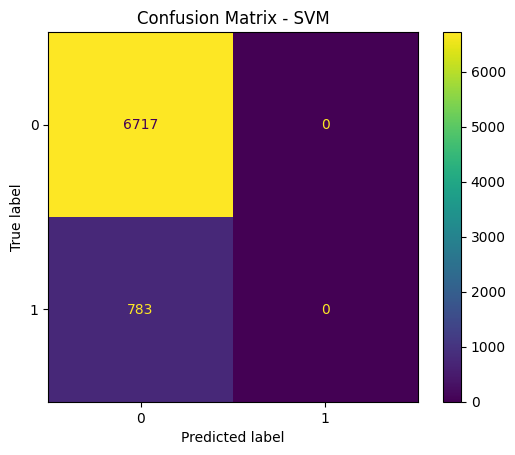

Random Forest Confusion Matrix:
[[6708    9]
 [ 775    8]]


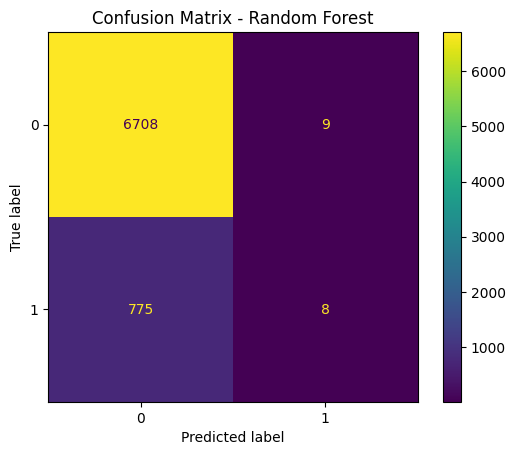

XGBoost Confusion Matrix:
[[6619   98]
 [ 717   66]]


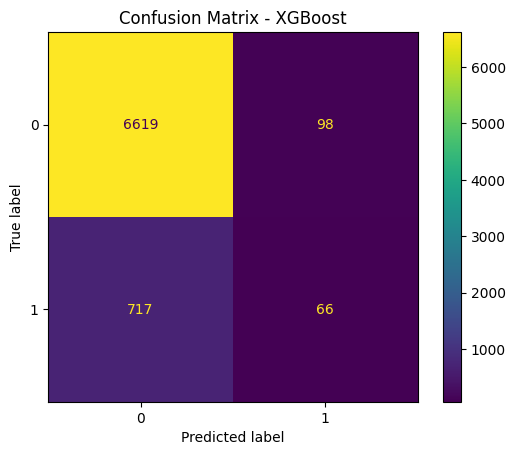

In [120]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Logistic Regression
y_pred_lr = lr_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

# SVM
y_pred_svm = svm_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

# Random Forest
y_pred_test = rf_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_test, "Random Forest")

# XGBoost
y_pred_xgb = xgb_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

### Plotting confusion matrix for tuned models

Logistic Regression Tuned Confusion Matrix:
[[6657   60]
 [ 719   64]]


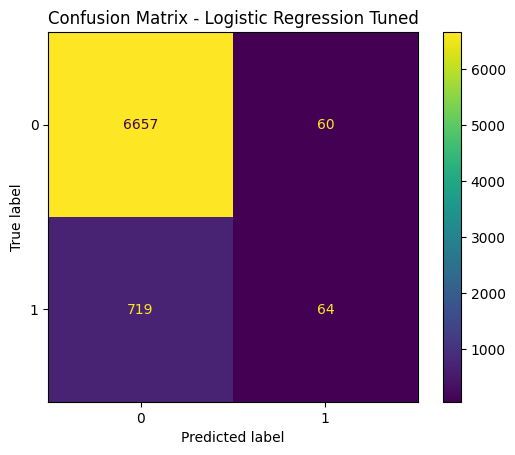

SVM Tuned Confusion Matrix:
[[6717    0]
 [ 783    0]]


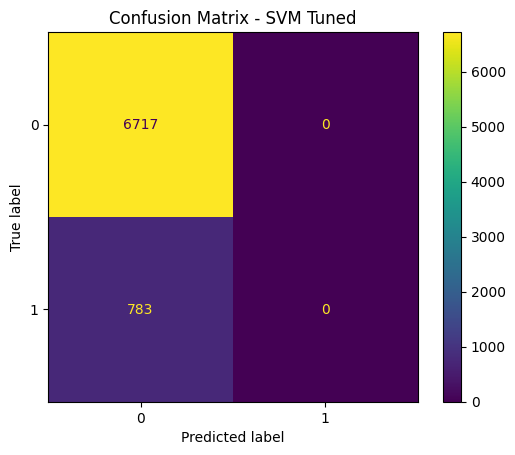

Random Forest Tuned Confusion Matrix:
[[6715    2]
 [ 780    3]]


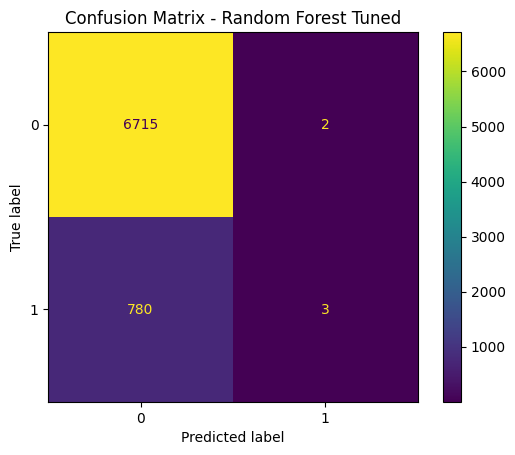

XGBoost Tuned Confusion Matrix:
[[6715    2]
 [ 777    6]]


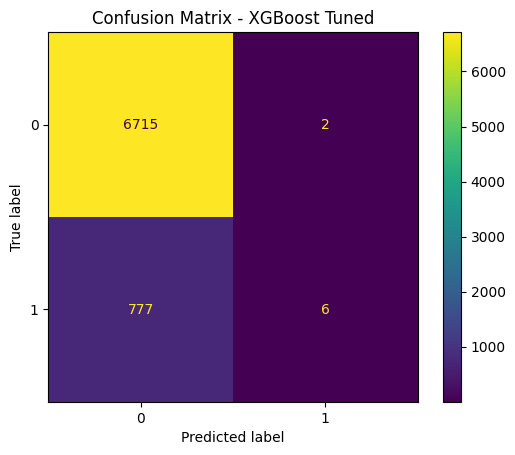

In [122]:
# Logistic Regression
y_pred_lr = lr_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression Tuned")

# SVM
y_pred_svm = svm_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, "SVM Tuned")

# Random Forest
y_pred_test = rf_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_test, "Random Forest Tuned")

# XGBoost
y_pred_xgb = xgb_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Tuned")

In [123]:
consolidated_evaluation_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.895467,0.470588,0.010217,0.020000,0.504439
1,Logistic Regression,0.898533,0.583333,0.098340,0.168306,0.545076
2,SVM,0.895600,0.000000,0.000000,0.000000,0.500000
3,XGBoost,0.891333,0.402439,0.084291,0.139388,0.534851
4,Random Forest (Tuned),0.895733,0.600000,0.003831,0.007614,0.501767
5,Logistic Regression (Tuned),0.896133,0.516129,0.081737,0.141125,0.536402
6,SVM (Tuned),0.895600,0.000000,0.000000,0.000000,0.500000
7,XGBoost (Tuned),0.896133,0.750000,0.007663,0.015171,0.503683


### Plotting feature importance for top 20 words

In [124]:
# Function to plot feature importance (top 20 as default)
def plot_top_n_feature_importance(importance, names, model_name, top_n=20):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    top_features = feature_importance.head(top_n)
    plt.figure(figsize=(20, 12))
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.show()

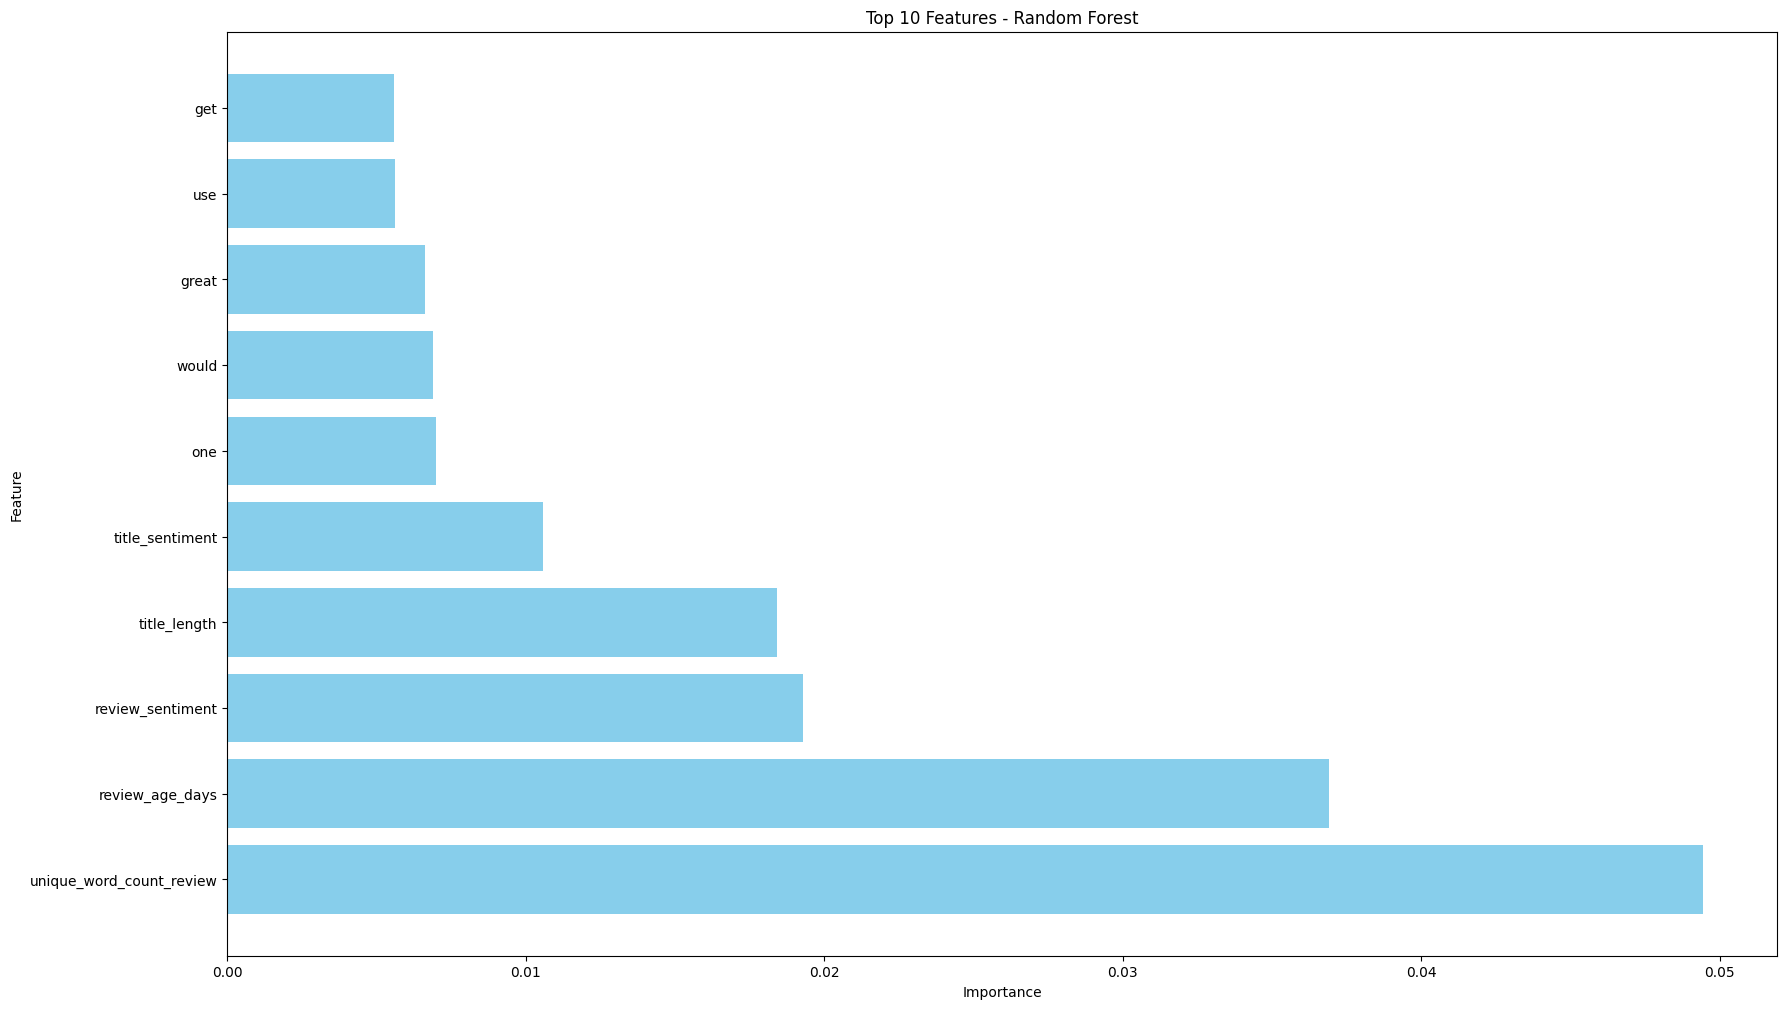

In [125]:
# Random Forest Feature Importance
#rf_feature_importance = rf_best_model.feature_importances_
rf_feature_importance = rf_classifier.feature_importances_
plot_top_n_feature_importance(rf_feature_importance, X_train.columns, 'Random Forest', 10)

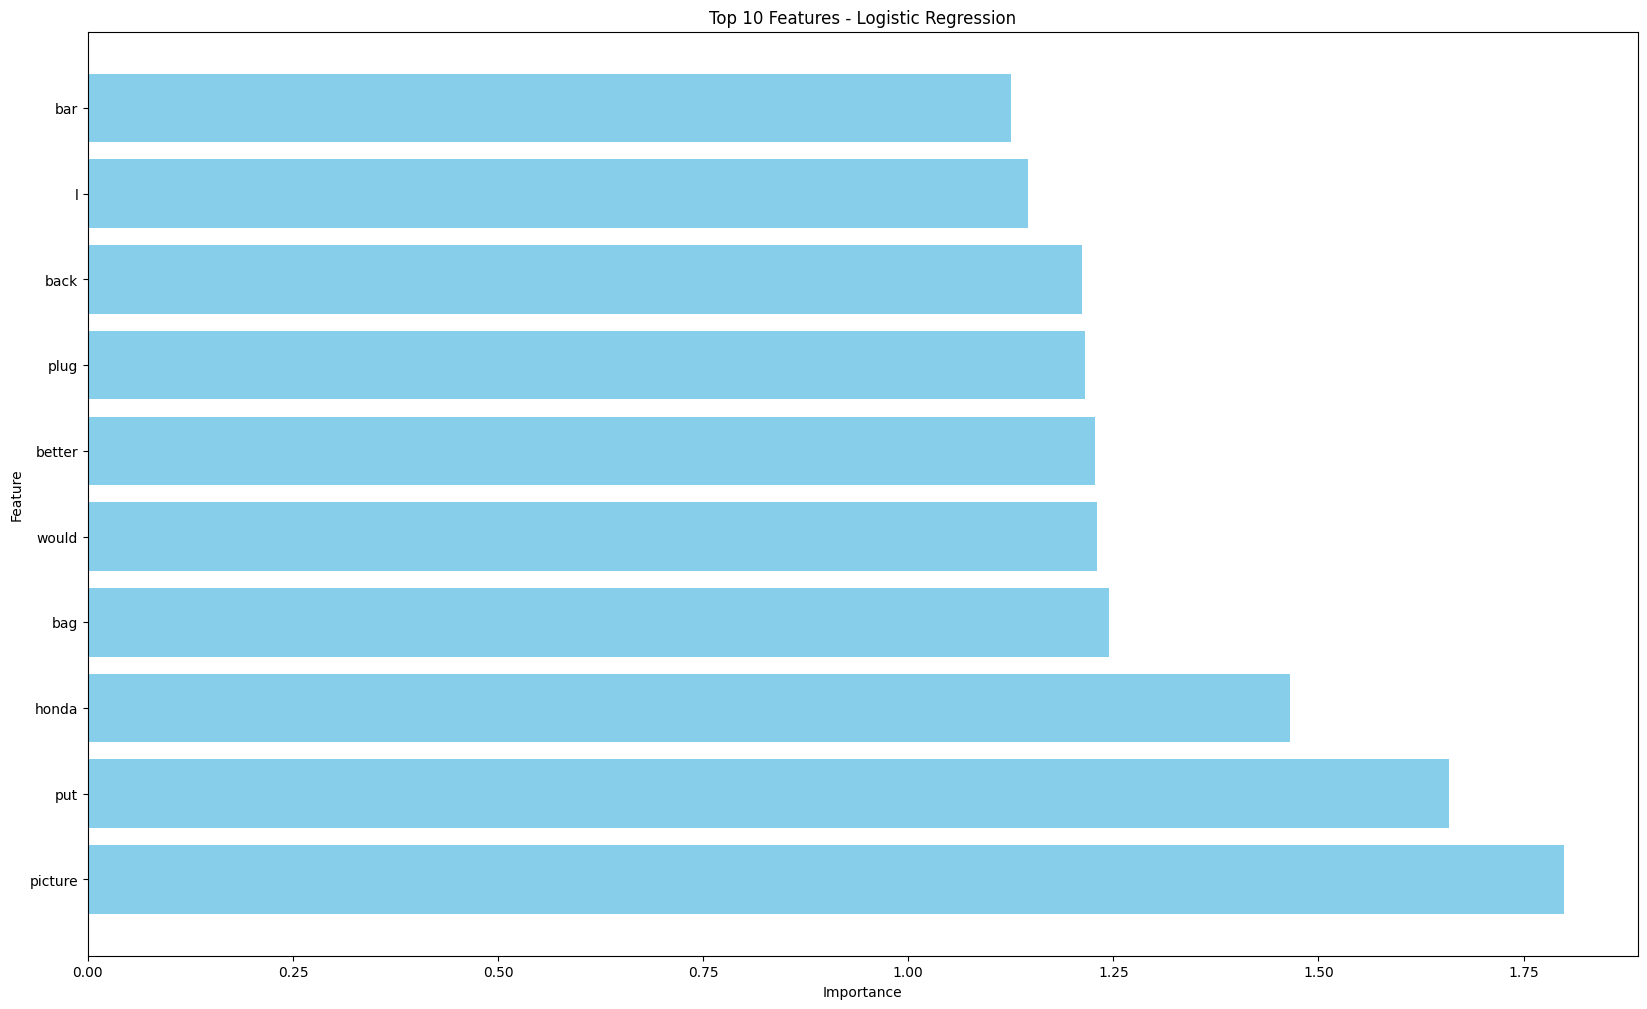

In [126]:
# Logistic Regression Coefficients (for positive and negative impact)
#lr_feature_importance = lr_best_model.coef_[0]
lr_feature_importance = lr_classifier.coef_[0]
plot_top_n_feature_importance(lr_feature_importance, X_train.columns, 'Logistic Regression', 10)

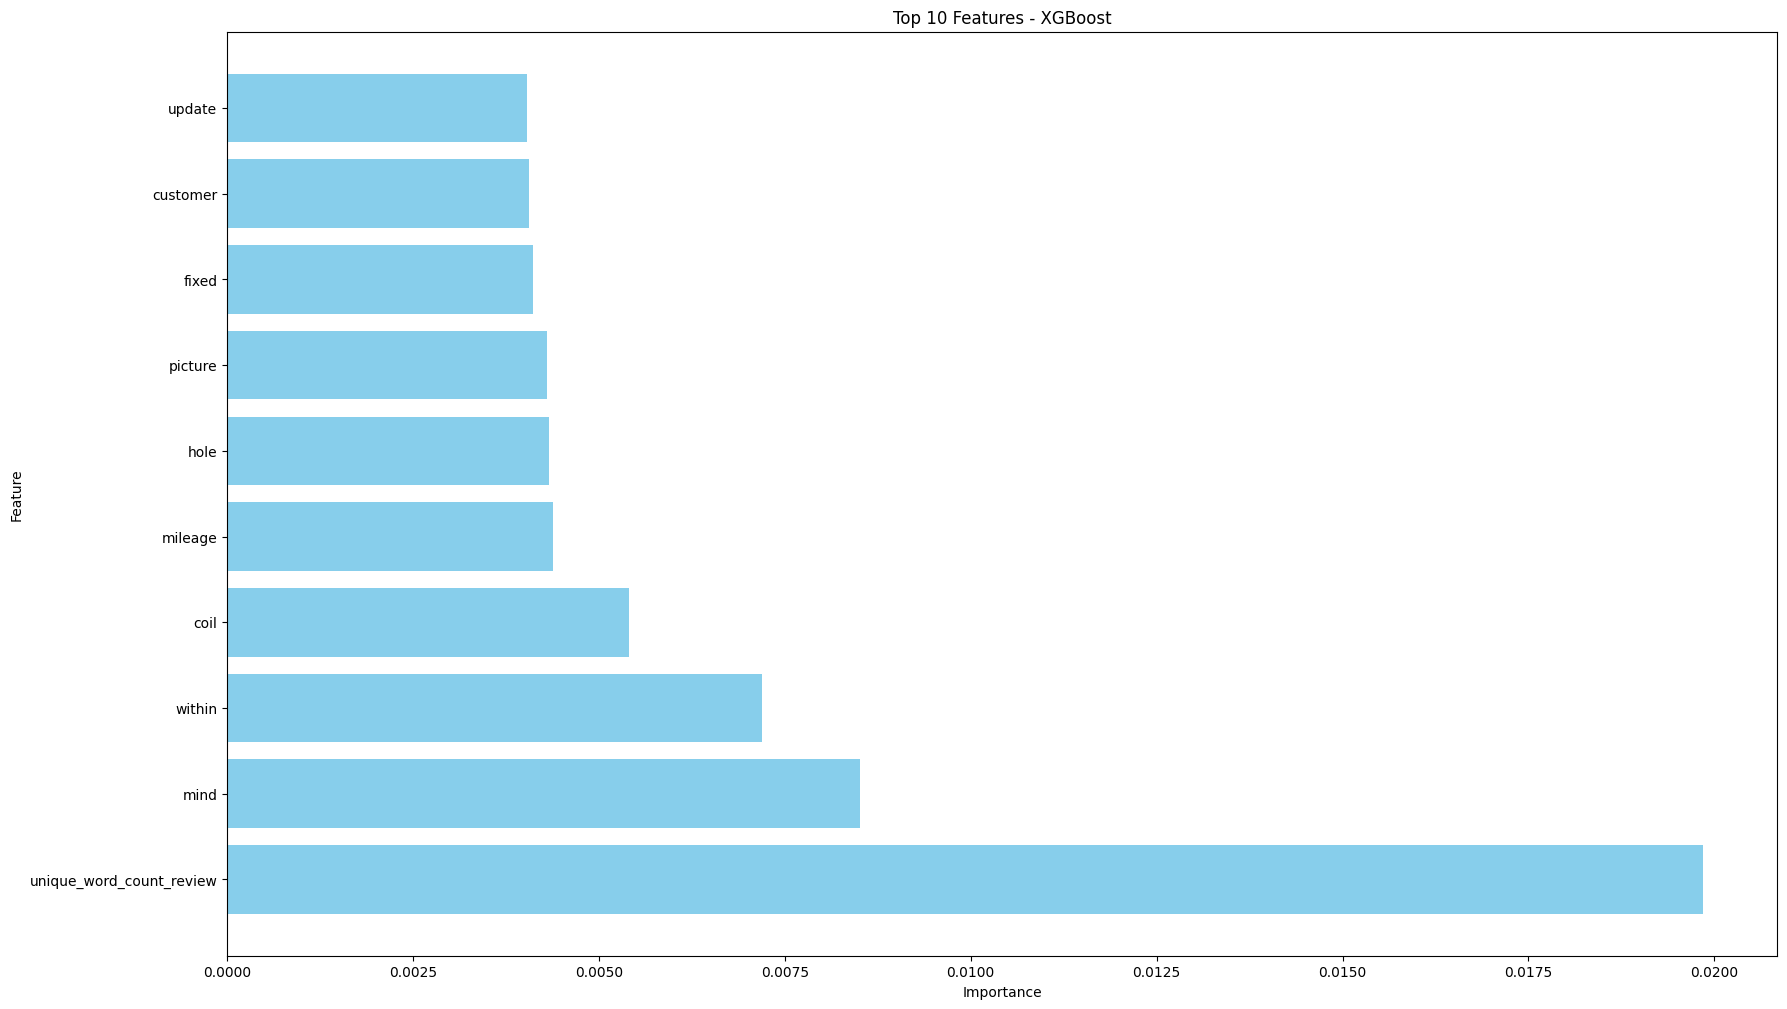

In [127]:
# XGBoost Feature Importance
#xgb_feature_importance = xgb_best_model.feature_importances_
xgb_feature_importance = xgb_classifier.feature_importances_
plot_top_n_feature_importance(xgb_feature_importance, X_train.columns, 'XGBoost', 10)

In [128]:
X_train.columns

Index(['able', 'absolutely', 'ac', 'access', 'accord', 'accurate', 'actually',
       'adapter', 'add', 'added',
       ...
       'yet', 'youtube', 'title_length', 'title_sentiment',
       'emoji_non_ascii_count_title', 'review_sentiment', 'url_count_review',
       'unique_word_count_review', 'review_age_days', 'image_available'],
      dtype='object', length=1008)

### Model explainability and drivers of helpfulness

In [129]:
def plot_imp_feature_distribution_hist(df, feature_name, target_column):
    sns.set(style="whitegrid", rc={"grid.linewidth": 0})  # rc parameter to be tweaked to get gridlines
    plt.figure(figsize=(8, 6))

    # Plotting histogram for non-helpful cases
    sns.histplot(data=df[df[target_column] == 0], x=feature_name, color='skyblue', label='Not Helpful', kde=True)

    # Plotting histogram for helpful cases
    sns.histplot(data=df[df[target_column] == 1], x=feature_name, color='salmon', label='Helpful', kde=True)

    plt.title(f'Distribution of {feature_name} across Helpfulness Levels')
    plt.xlabel(feature_name)
    plt.ylabel('Count')

    plt.legend()

    plt.show()

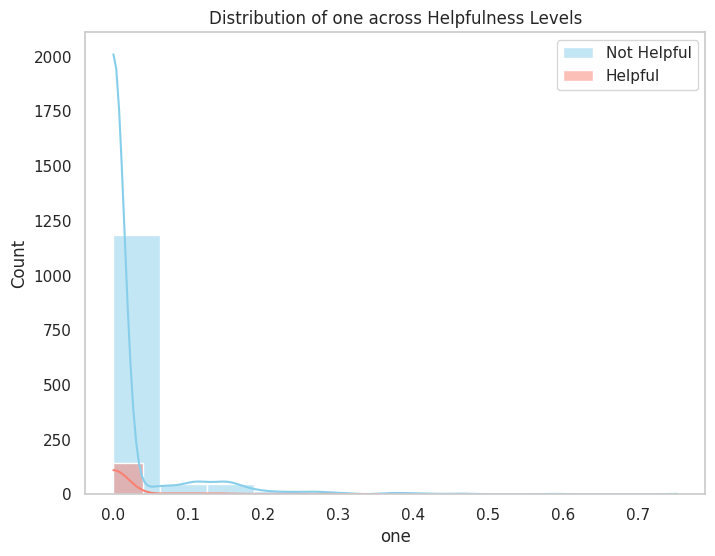

In [130]:
# Specifying the (important) feature that needs to be explored across helpfulness values
feature_to_explore = 'one'

# Plotting the feature distribution across helpfulness
plot_imp_feature_distribution_hist(pd.concat([X, y], axis=1), feature_to_explore, 'helpfulness_binary')

In [136]:
y

18214      0
365664     0
608685     0
258863     0
404634     0
          ..
1414487    1
1387521    1
1214463    1
1346361    1
1703637    1
Name: helpfulness_binary, Length: 50002, dtype: int64

#### For tree-based models (Random Forest / XGBoost) - feature importance of review terms

In [137]:
# Specifying the tree based classifier instance to get the feature importance values
#feature_importances = rf_classifier.feature_importances_
feature_importances = xgb_classifier.feature_importances_

# Obtaining feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting the dictionary by importance (descending order)
sorted_feature_importance_desc = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the top N important terms along with their relative importance
top_n = 20
for term, importance in sorted_feature_importance_desc[:top_n]:
    print(f"Review term: {term}, Importance: {importance}")

Review term: mind, Importance: 0.008515208028256893
Review term: within, Importance: 0.0071963537484407425
Review term: coil, Importance: 0.005401560105383396
Review term: mileage, Importance: 0.004377749748528004
Review term: hole, Importance: 0.004334561061114073
Review term: picture, Importance: 0.004306472837924957
Review term: fixed, Importance: 0.004114856477826834
Review term: customer, Importance: 0.0040653967298567295
Review term: update, Importance: 0.004037804435938597
Review term: drive, Importance: 0.003963550087064505
Review term: went, Importance: 0.003792133182287216
Review term: total, Importance: 0.003757764585316181
Review term: tape, Importance: 0.0037190138828009367
Review term: might, Importance: 0.003714548423886299
Review term: case, Importance: 0.0037022759206593037
Review term: tip, Importance: 0.0036893398500978947
Review term: getting, Importance: 0.0036876124795526266
Review term: damage, Importance: 0.0036032104399055243
Review term: whole, Importance: 0.0

### Shapley Values

In [138]:

# Creating explainer objects for each model

# For XGBoost base model
xgb_explainer_base = shap.TreeExplainer(xgb_classifier)
# For XGBoost tuned model
xgb_explainer_tuned = shap.TreeExplainer(xgb_best_model)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [140]:
# Using the explainer objects to calculate SHAP values for the test dataset

# For XGBoost base model
xgb_shap_base_values = xgb_explainer_base(X_test)

# For XGBoost tuned model
xgb_shap_tuned_values = xgb_explainer_tuned(X_test)

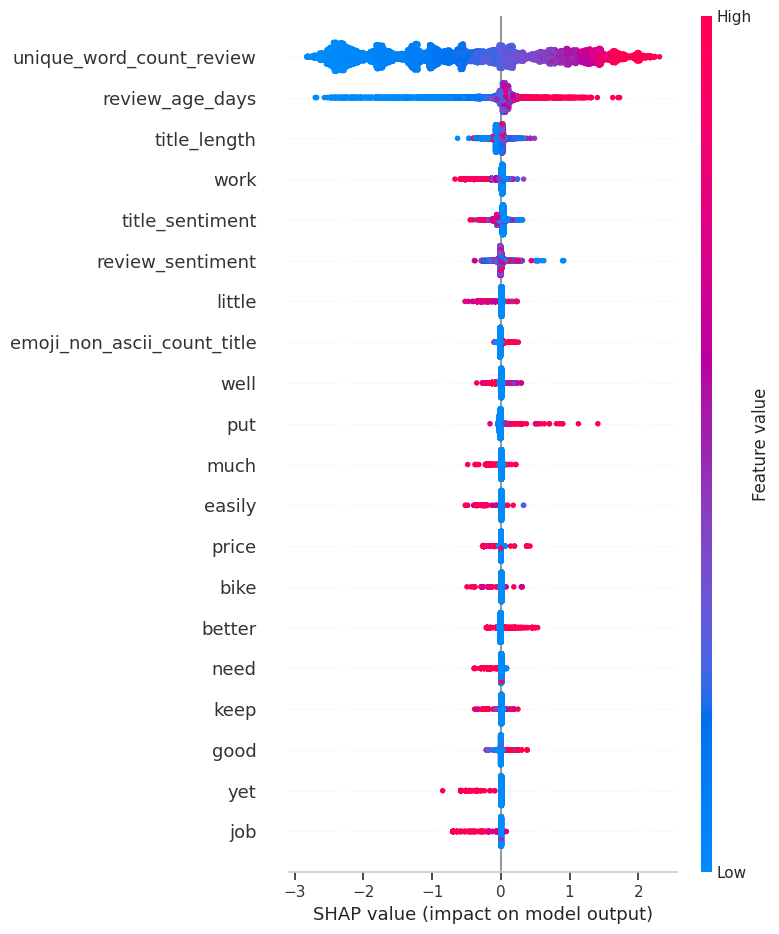

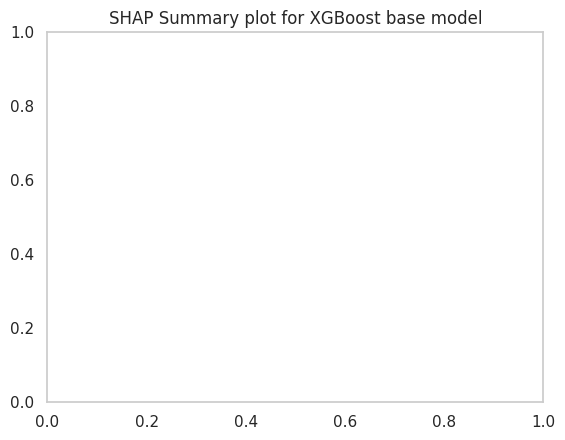

In [141]:
# summary_plot will generate summary plots for each model, showing the distribution of SHAP values for each feature 
# Features are sorted by their importance, with the most important features at the top 
# The color of each point indicates the value of the feature (red for high values, blue for low values) 
# The position of the point on the x-axis indicates the impact of that feature on the model's output

# Plot for XGBoost base model
shap.summary_plot(xgb_shap_base_values, X_test, feature_names=X_train.columns)
# Adding title to the plot
plt.title('SHAP Summary plot for XGBoost base model')
# Displaying the plot
plt.show()

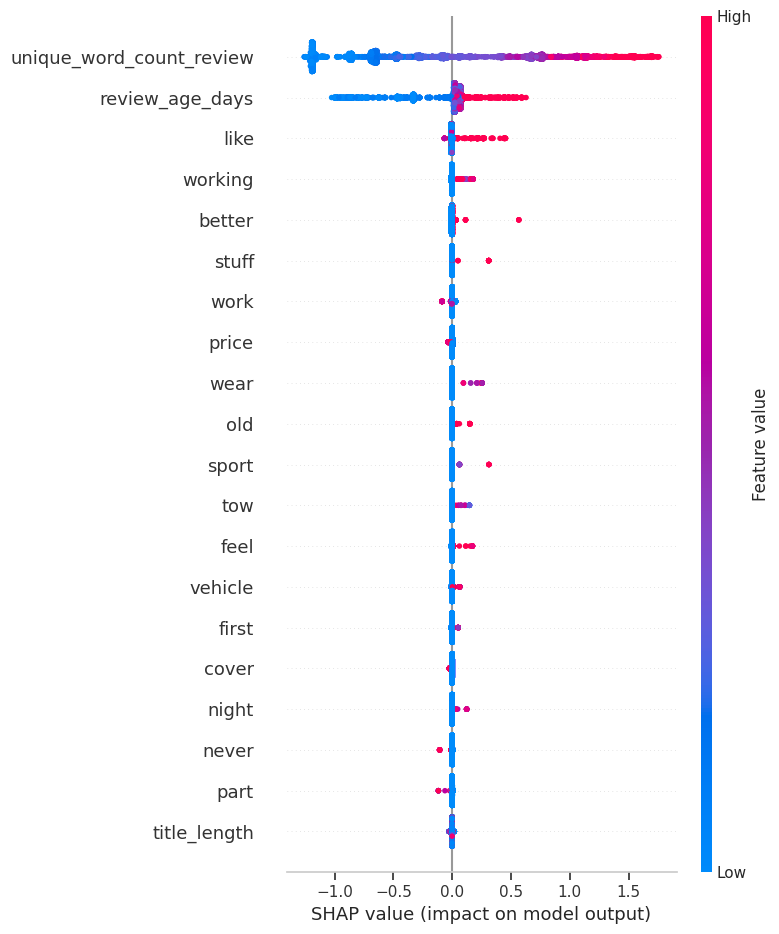

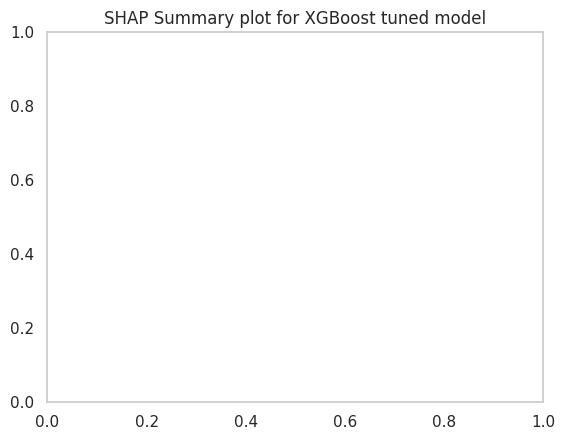

In [142]:
# summary_plot will generate summary plots for each model, showing the distribution of SHAP values for each feature 
# Features are sorted by their importance, with the most important features at the top 
# The color of each point indicates the value of the feature (red for high values, blue for low values) 
# The position of the point on the x-axis indicates the impact of that feature on the model's output

# Plot for XGBoost tuned model
shap.summary_plot(xgb_shap_tuned_values, X_test, feature_names=X_train.columns)
# Adding title to the plot
plt.title('SHAP Summary plot for XGBoost tuned model')
# Displaying the plot
plt.show()

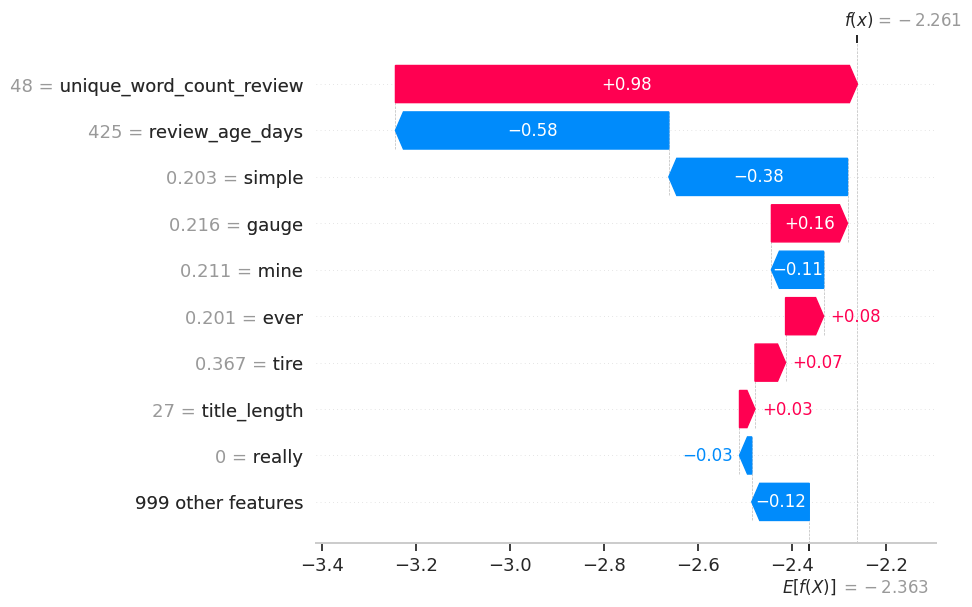

In [143]:
# Visualizing the first prediction's explanation using a waterfall plot
# The chart shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output 
# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

# XGBoost base model waterfall plot
shap.plots.waterfall(xgb_shap_base_values[0])

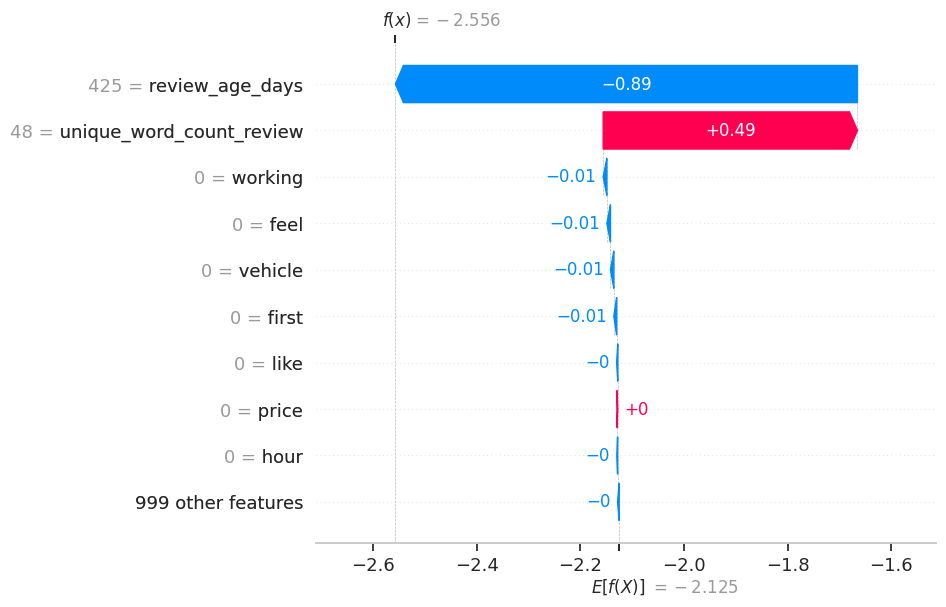

In [144]:
# Visualizing the first prediction's explanation using a waterfall plot
# The chart shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output 
# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

# XGBoost tuned model waterfall plot
shap.plots.waterfall(xgb_shap_tuned_values[0])

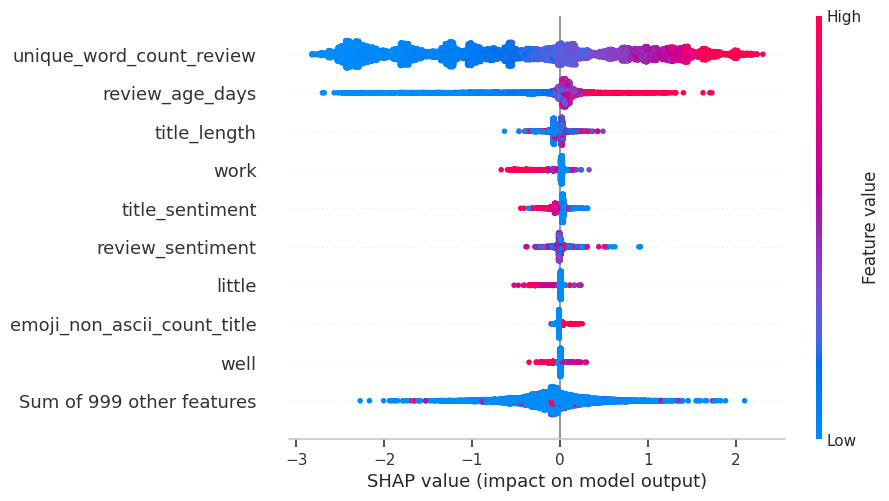

In [145]:
# Summarizing the effects of all the features
# The plot below sorts features by the sum of SHAP value magnitudes over all samples 
# It uses SHAP values to show the distribution of the impacts each feature has on the model output 
# The color represents the feature value (red high, blue low) 
# Greater concentration of red for a feature will indicate that the feature positively affects helpfulness

# XGBoost base model beeswarm plot
shap.plots.beeswarm(xgb_shap_base_values)

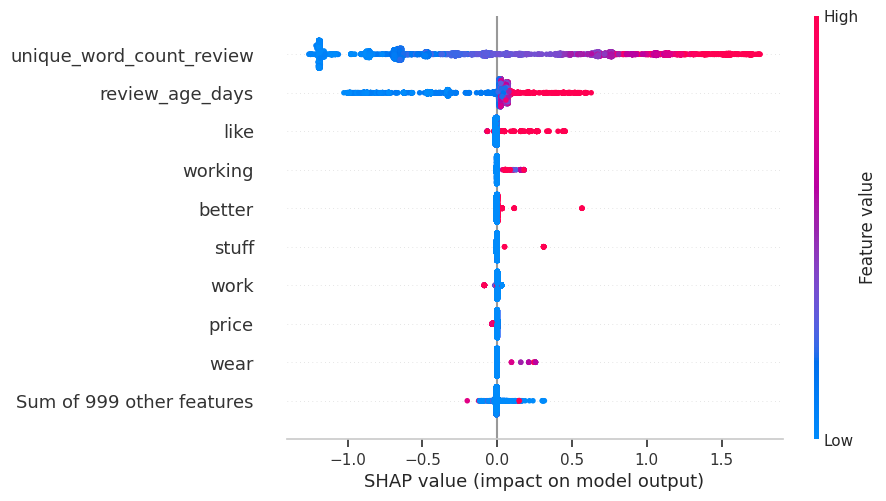

In [146]:
# Summarizing the effects of all the features
# The plot below sorts features by the sum of SHAP value magnitudes over all samples 
# It uses SHAP values to show the distribution of the impacts each feature has on the model output 
# The color represents the feature value (red high, blue low) 
# Greater concentration of red for a feature will indicate that the feature positively affects helpfulness

# XGBoost tuned model beeswarm plot
shap.plots.beeswarm(xgb_shap_tuned_values)

Models for Automotive have high accuracy but low precision and recall, it is due to the fact that our data is imbalanced and has high dimentionality. 
Data has the majority class as “Not Helpful” with “Helpful” being the minority class.
It's representative of real world data since helpful reviews are limited and exclusive. Since metadata and TF-IDF features are used, there is a high number of dimensions.
Iterations of the model with limited TF-IDF features (100), a larger TF-IDF feature matrix (2000), and another iteration with only metadata features was attempted however, the results did not change much across the iterations, indicating that current set of features are not adequate to accurately predict helpfulness.

Thank You!!!